In [15]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd, numpy as np, csv
from pathlib import Path

ruta = '/content/drive/MyDrive/Proyecto final/FLAT_RCL_POST_2010.txt'

# --- 1) Lectura tolerante y tab-delimited ---
read_kwargs = dict(
    sep="\t",
    header=None,           # según Appendix no hay encabezados
    engine="python",
    dtype=str,
    na_filter=True,
    on_bad_lines="warn",
    quoting=csv.QUOTE_NONE
)
df = pd.read_csv(ruta, **read_kwargs)

# --- 2) Asignar nombres EXACTOS según Appendix A (1..24) ---
oficiales = [
    'RECORD_ID','CAMPNO','MAKETXT','MODELTXT','YEARTXT','MFGCAMPNO','COMPNAME','MFGNAME',
    'BGMAN','ENDMAN','RCLTYPECD','POTAFF','ODATE','INFLUENCED_BY','MFGTXT','RCDATE',
    'DATEA','RPNO','FMVSS','DESC_DEFECT','CONEQUENCE_DEFECT','CORRECTIVE_ACTION',
    'NOTES','RCL_CMPT_ID'
]
ncols = df.shape[1]
df.columns = [f'c{i+1:02d}' for i in range(ncols)]
for i, name in enumerate(oficiales[:ncols], start=1):
    df.rename(columns={f'c{i:02d}': name}, inplace=True)

# --- 3) Normalización de nombres problemáticos (typo del Appendix) ---
# Unificamos a 'CONSEQUENCE_DEFECT'
rename_map = {}
if 'CONEQUENCE_DEFECT' in df.columns:
    rename_map['CONEQUENCE_DEFECT'] = 'CONSEQUENCE_DEFECT'
if 'CONSEQUENCE_DEFECT' in df.columns:
    # ya está; no pasa nada
    pass
df.rename(columns=rename_map, inplace=True)

# --- 4) Tipificación y limpieza coherente con Appendix ---
# YEARTXT: 9999 -> NaN, rango plausible
if 'YEARTXT' in df.columns:
    df['YEARTXT'] = pd.to_numeric(df['YEARTXT'].replace({'9999': None}), errors='coerce')
    df.loc[(df['YEARTXT'] < 1950) | (df['YEARTXT'] > 2035), 'YEARTXT'] = pd.NA

# Fechas YYYYMMDD: incluye BGMAN/ENDMAN además de ODATE/RCDATE/DATEA
for col in ['ODATE','RCDATE','DATEA','BGMAN','ENDMAN']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], format='%Y%m%d', errors='coerce')

# POTAFF numérico
if 'POTAFF' in df.columns:
    df['POTAFF_num'] = pd.to_numeric(df['POTAFF'], errors='coerce')

# --- 5) Longitud de campos de texto largos para outliers/NLP ---
for c in ['DESC_DEFECT','CONSEQUENCE_DEFECT','CORRECTIVE_ACTION','NOTES']:
    if c in df.columns:
        df[f'len_{c}'] = df[c].fillna('').str.len()

# --- 6) Tablas a NIVEL CAMPAÑA (evita sobreconteo al sumar POTAFF) ---
agg_cols = {
    'POTAFF_num':'max',        # se repite por fila; elegir max/first
    'MFGNAME':'first',
    'MAKETXT':'first',
    'RCLTYPECD':'first',
    'COMPNAME':'first',
    'FMVSS':'first',
    'RCDATE':'min',            # fecha “recibida” por campaña
    'ODATE':'min',
    'DATEA':'min',
    'BGMAN':'min',
    'ENDMAN':'max'
}
present = {k:v for k,v in agg_cols.items() if k in df.columns}
by_camp = df.groupby('CAMPNO', as_index=False).agg(**{k:(k,v) for k,v in present.items()})

# --- 7) Guardados útiles ---
out_dir = Path('/content/drive/MyDrive/Proyecto final')
out_dir.mkdir(parents=True, exist_ok=True)

df.to_csv(out_dir/'recalls_raw_rows.csv', index=False)            # filas originales
by_camp.to_csv(out_dir/'recalls_by_campaign.csv', index=False)    # 1 fila por campaña

print("Crudo (filas):", df.shape, " | Por campaña:", by_camp.shape)
print("Columnas:", df.columns.tolist())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Crudo (filas): (221835, 34)  | Por campaña: (14290, 12)
Columnas: ['RECORD_ID', 'CAMPNO', 'MAKETXT', 'MODELTXT', 'YEARTXT', 'MFGCAMPNO', 'COMPNAME', 'MFGNAME', 'BGMAN', 'ENDMAN', 'RCLTYPECD', 'POTAFF', 'ODATE', 'INFLUENCED_BY', 'MFGTXT', 'RCDATE', 'DATEA', 'RPNO', 'FMVSS', 'DESC_DEFECT', 'CONSEQUENCE_DEFECT', 'CORRECTIVE_ACTION', 'NOTES', 'RCL_CMPT_ID', 'c25', 'c26', 'c27', 'c28', 'c29', 'POTAFF_num', 'len_DESC_DEFECT', 'len_CONSEQUENCE_DEFECT', 'len_CORRECTIVE_ACTION', 'len_NOTES']


In [16]:
df

,RECORD_ID,CAMPNO,MAKETXT,MODELTXT,YEARTXT,MFGCAMPNO,COMPNAME,MFGNAME,BGMAN,ENDMAN,...,c25,c26,c27,c28,c29,POTAFF_num,len_DESC_DEFECT,len_CONSEQUENCE_DEFECT,len_CORRECTIVE_ACTION,len_NOTES
0,81715,10V559000,K-Z,NEW VISION,2005.0,NaN,EQUIPMENT,"KZRV, L.P.",NaT,NaT,...,NaN,NaN,NaN,No,No,552,235,28,224,210
1,81716,10V559000,KZRV,MONTEGO BAY,2008.0,NaN,EQUIPMENT,"KZRV, L.P.",NaT,NaT,...,NaN,NaN,NaN,No,No,552,235,28,224,210
2,81717,10V484000,CARRIAGE,CAMEO,2008.0,NaN,EQUIPMENT,"CARRIAGE, INC",NaT,NaT,...,NaN,NaN,NaN,No,No,394,239,43,228,210
3,81718,10V484000,CARRIAGE,CAMEO,2010.0,NaN,EQUIPMENT,"CARRIAGE, INC",NaT,NaT,...,NaN,NaN,NaN,No,No,394,239,43,228,210
4,81719,10V454000,FOREST RIVER,CARDINAL,2003.0,NaN,EQUIPMENT,"FOREST RIVER, INC.",NaT,NaT,...,NaN,NaN,NaN,No,No,2207,243,43,239,210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221830,303545,25V595000,TOYOTA,TACOMA,2025.0,See Part 573 Report,ELECTRICAL SYSTEM: INSTRUMENT CLUSTER/PANEL,Toyota Motor Engineering & Manufacturing,NaT,2024-11-14,...,"Meter Assy, Combination",Combination Meter,83800-3AV22,No,No,591377,482,111,467,0
221831,303546,25V595000,TOYOTA,TACOMA,2025.0,See Part 573 Report,ELECTRICAL SYSTEM: INSTRUMENT CLUSTER/PANEL,Toyota Motor Engineering & Manufacturing,NaT,2024-11-14,...,"Meter Assy, Combination",Combination Meter,83800-3AV21,No,No,591377,482,111,467,0
221832,303547,25V595000,TOYOTA,TACOMA,2025.0,See Part 573 Report,ELECTRICAL SYSTEM: INSTRUMENT CLUSTER/PANEL,Toyota Motor Engineering & Manufacturing,NaT,2024-11-14,...,"Meter Assy, Combination",Combination Meter,83800-3AV20,No,No,591377,482,111,467,0
221833,303548,25V595000,TOYOTA,TACOMA,2025.0,See Part 573 Report,ELECTRICAL SYSTEM: INSTRUMENT CLUSTER/PANEL,Toyota Motor Engineering & Manufacturing,NaT,2024-11-14,...,"Meter Assy, Combination",Combination Meter,83800-3AU72,No,No,591377,482,111,467,0


In [17]:
# === Limpieza IN-PLACE sobre el df ya cargado ===
import pandas as pd
import numpy as np
from pathlib import Path

# ---------- 0) Auditoría inicial ----------
audit = {}
audit['rows_before'] = len(df)
audit['cols_before'] = df.shape[1]
audit['campaigns_before'] = df['CAMPNO'].nunique() if 'CAMPNO' in df.columns else None

# ---------- 1) Normalización de nombres problemáticos ----------
# El Appendix trae el campo 21 como CONEQUENCE_DEFECT; unificamos a CONSEQUENCE_DEFECT
if 'CONEQUENCE_DEFECT' in df.columns and 'CONSEQUENCE_DEFECT' not in df.columns:
    df.rename(columns={'CONEQUENCE_DEFECT': 'CONSEQUENCE_DEFECT'}, inplace=True)

# ---------- 2) YEARTXT: 9999 -> NaN, entero nullable y rangos plausibles ----------
if 'YEARTXT' in df.columns:
    yr_raw = pd.to_numeric(df['YEARTXT'], errors='coerce')
    n_9999 = (df['YEARTXT'] == '9999').sum() if df['YEARTXT'].dtype == object else 0
    audit['year_9999_to_NA'] = int(n_9999)

    yr = pd.to_numeric(df['YEARTXT'].replace({'9999': None}), errors='coerce')
    invalid_mask = (yr < 1950) | (yr > 2035)
    audit['year_out_of_range_to_NA'] = int(invalid_mask.fillna(False).sum())
    yr[invalid_mask] = pd.NA
    df['YEARTXT'] = yr.astype('Int64')

# ---------- 3) Fechas: parseo YYYYMMDD (incluye BGMAN/ENDMAN) ----------
date_cols = [c for c in ['ODATE','RCDATE','DATEA','BGMAN','ENDMAN'] if c in df.columns]
for col in date_cols:
    # cuenta cuántas eran parseables (estimado comparando antes/después)
    before_non_na = df[col].notna().sum()
    df[col] = pd.to_datetime(df[col], format='%Y%m%d', errors='coerce')
    after_parsed = df[col].notna().sum()
    audit[f'parsed_{col}'] = int(after_parsed)
    audit[f'failed_parse_{col}'] = int(max(0, before_non_na - after_parsed))

# ---------- 4) POTAFF a numérico ----------
if 'POTAFF' in df.columns:
    not_num_before = (pd.to_numeric(df['POTAFF'], errors='coerce').isna() & df['POTAFF'].notna()).sum()
    df['POTAFF_num'] = pd.to_numeric(df['POTAFF'], errors='coerce')
    audit['potaff_non_numeric_to_NA'] = int(not_num_before)

# ---------- 5) Longitudes de textos largos (útiles para outliers/NLP) ----------
text_fields = [c for c in ['DESC_DEFECT','CONSEQUENCE_DEFECT','CORRECTIVE_ACTION','NOTES'] if c in df.columns]
for c in text_fields:
    df[f'len_{c}'] = df[c].fillna('').astype(str).str.len()

# ---------- 6) Vista por campaña (evita sobrecontar POTAFF) ----------
if 'CAMPNO' in df.columns:
    agg_cols = {
        'POTAFF_num':'max',      # suele repetirse por fila
        'MFGNAME':'first',
        'MAKETXT':'first',
        'MODELTXT':'first',      # primer modelo asociado (opcional)
        'COMPNAME':'first',
        'RCLTYPECD':'first',
        'FMVSS':'first',
        'RCDATE':'min',
        'ODATE':'min',
        'DATEA':'min',
        'BGMAN':'min',
        'ENDMAN':'max',
        'YEARTXT':'max'          # año más reciente asociado (puedes cambiar a 'first' si prefieres)
    }
    present = {k:v for k,v in agg_cols.items() if k in df.columns}
    by_camp = df.groupby('CAMPNO', as_index=False).agg(**{k:(k,v) for k,v in present.items()})

    # Flags de cobertura de texto a nivel campaña (True si existe al menos un texto no vacío en la campaña)
    for c in text_fields:
        tmp = (df.groupby('CAMPNO')[c]
                 .apply(lambda s: s.fillna('').astype(str).str.len().gt(0).any())
                 .rename(f'has_{c.lower()}'))
        by_camp = by_camp.merge(tmp, on='CAMPNO', how='left')

    audit['campaigns_after'] = len(by_camp)
    audit['rows_to_campaign_ratio'] = round(audit['rows_before'] / audit['campaigns_after'], 3) if audit['campaigns_after'] else None
else:
    by_camp = None

# ---------- 7) Guardados ----------
out_dir = Path('/content/drive/MyDrive/Proyecto final')
out_dir.mkdir(parents=True, exist_ok=True)

# a) crudo enriquecido (misma granularidad original, con tipos/longitudes)
raw_path = out_dir / 'recalls_raw_enriched.csv'
df.to_csv(raw_path, index=False)

# b) por campaña (si se pudo construir)
camp_path = out_dir / 'recalls_by_campaign.csv'
if by_camp is not None:
    # exportamos columnas más estables/útiles
    cols_export = [c for c in [
        'CAMPNO','RECORD_ID',
        'MFGNAME','MAKETXT','MODELTXT',
        'RCLTYPECD','COMPNAME','FMVSS',
        'YEARTXT','BGMAN','ENDMAN',
        'POTAFF_num',
        'RCDATE','ODATE','DATEA',
        'has_desc_defect','has_consequence_defect','has_corrective_action','has_notes'
    ] if c in by_camp.columns]
    by_camp[cols_export].to_csv(camp_path, index=False)

# ---------- 8) Resumen de auditoría  ----------
print("=== AUDITORÍA DE LIMPIEZA ===")
for k,v in audit.items():
    print(f"{k:28s}: {v}")
print(f"\n[OK] Guardado CRUDO enriquecido -> {raw_path}")
if by_camp is not None:
    print(f"[OK] Guardado POR CAMPAÑA       -> {camp_path}")

# ---------- 9) Ejemplos rápidos de sanity check ----------
# - Campaña con múltiples filas (si existe), muestra consolidación
if by_camp is not None:
    samp = df['CAMPNO'].value_counts().head(1).index.tolist()
    if samp:
        cno = samp[0]
        print(f"\nEjemplo campaña '{cno}': filas={ (df['CAMPNO']==cno).sum() }")
        display(by_camp.loc[by_camp['CAMPNO']==cno].head(1))


=== AUDITORÍA DE LIMPIEZA ===
rows_before                 : 221835
cols_before                 : 34
campaigns_before            : 14290
year_9999_to_NA             : 0
year_out_of_range_to_NA     : 0
parsed_ODATE                : 214678
failed_parse_ODATE          : 0
parsed_RCDATE               : 221835
failed_parse_RCDATE         : 0
parsed_DATEA                : 221835
failed_parse_DATEA          : 0
parsed_BGMAN                : 68824
failed_parse_BGMAN          : 0
parsed_ENDMAN               : 68703
failed_parse_ENDMAN         : 0
potaff_non_numeric_to_NA    : 0
campaigns_after             : 14290
rows_to_campaign_ratio      : 15.524

[OK] Guardado CRUDO enriquecido -> /content/drive/MyDrive/Proyecto final/recalls_raw_enriched.csv
[OK] Guardado POR CAMPAÑA       -> /content/drive/MyDrive/Proyecto final/recalls_by_campaign.csv

Ejemplo campaña '24T014000': filas=19321


,CAMPNO,POTAFF_num,MFGNAME,MAKETXT,MODELTXT,COMPNAME,RCLTYPECD,FMVSS,RCDATE,ODATE,DATEA,BGMAN,ENDMAN,YEARTXT,has_desc_defect,has_consequence_defect,has_corrective_action,has_notes
12659,24T014000,541632,"Prinx Chengshan Tire North America, Inc.",FORTUNE,TORMENTA R/T FSR309,TIRES:MARKINGS,T,139,2024-12-09,2025-01-27,2024-12-09,NaT,NaT,<NA>,True,True,True,True


El campo `POTAFF` refleja el número de unidades potencialmente afectadas por cada campaña de recall. Validé que es consistente dentro de cada campaña (0 inconsistencias encontradas). El top 10 de campañas corresponde a casos emblemáticos (ej. airbags de Takata, ignition de GM), con entre 5 y 17 millones de unidades afectadas. Esto muestra que `POTAFF` es un buen indicador de magnitud del recall. Además, confirmamos que el archivo cubre mayormente recalls de vehículos completos (~90%), y que los campos de texto (defecto, consecuencia, acción correctiva, notas) tienen casi 100% de cobertura, lo que será útil en la etapa de análisis semántico.

Campañas con >1 valor distinto de POTAFF_num: 0


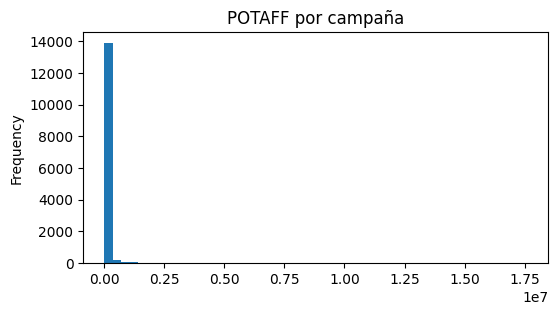

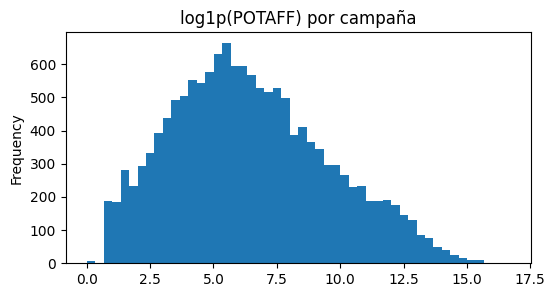

Top 10 campañas por POTAFF_num


,CAMPNO,MFGNAME,MAKETXT,COMPNAME,POTAFF_num
3659,15E040000,Takata Corporation,TAKATA,AIR BAGS:FRONTAL:DRIVER SIDE:INFLATOR MODULE,17600000
8511,20E001000,Takata (TK Global LLC),TAKATA,AIR BAGS:FRONTAL,10000000
4636,16E042000,Takata Corporation,TAKATA,AIR BAGS:FRONTAL:PASSENGER SIDE:INFLATOR MODULE,8500000
3660,15E041000,Takata Corporation,TAKATA,AIR BAGS:FRONTAL:PASSENGER SIDE:INFLATOR MODULE,7700000
4040,15V320000,Honda (American Honda Motor Co.),ACURA,AIR BAGS:FRONTAL:DRIVER SIDE:INFLATOR MODULE,6281043
3214,14V400000,General Motors LLC,CHEVROLET,ELECTRICAL SYSTEM:IGNITION,5877718
8520,20E010000,Kiekert USA,KIEKERT,LATCHES/LOCKS/LINKAGES:DOORS:LATCH,5641577
3661,15E042000,Takata Corporation,TAKATA,AIR BAGS:FRONTAL:PASSENGER SIDE:INFLATOR MODULE,5200000
4637,16E043000,Takata Corporation,TAKATA,AIR BAGS:FRONTAL:PASSENGER SIDE:INFLATOR MODULE,5100000
4602,16E007000,"Continental Automotive Systems, Inc.",CONTINENTAL AUTOMOTIVE,AIR BAGS,5000000


RCLTYPECD (conteo por tipo):


,count
RCLTYPECD,
V,12765
E,1275
T,187
C,63


/tmp/ipython-input-4261097502.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').size())


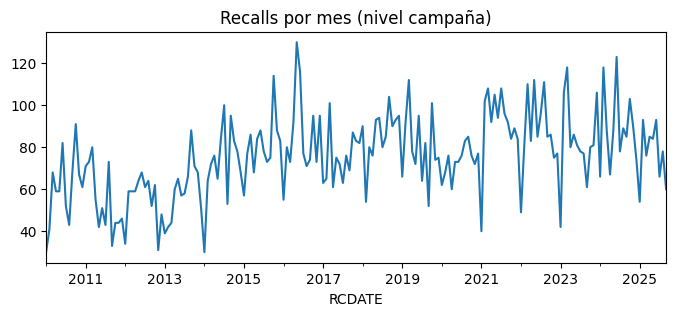

Cobertura de campos de texto (porcentaje de campañas con texto):


,0
has_desc_defect,100.0
has_consequence_defect,100.0
has_corrective_action,100.0
has_notes,97.7


In [18]:
# --- QC rápidos para anexar al informe ---

# 1) POTAFF consistente dentro de cada campaña (todas las filas deben coincidir con el valor agregado)
if {'CAMPNO','POTAFF_num'}.issubset(df.columns):
    var_por_camp = (df.groupby('CAMPNO')['POTAFF_num']
                      .agg(lambda s: pd.Series(s.unique()).size))  # cuántos valores distintos
    inconsistentes = var_por_camp[var_por_camp > 1].sort_values(ascending=False)
    print(f"Campañas con >1 valor distinto de POTAFF_num: {len(inconsistentes)}")
    if not inconsistentes.empty:
        display(inconsistentes.head(10))

# 2) Distribución y outliers de POTAFF a nivel campaña
import numpy as np, matplotlib.pyplot as plt
if 'POTAFF_num' in by_camp.columns:
    ax = by_camp['POTAFF_num'].plot(kind='hist', bins=50, figsize=(6,3), title='POTAFF por campaña')
    plt.show()
    ax = np.log1p(by_camp['POTAFF_num']).plot(kind='hist', bins=50, figsize=(6,3), title='log1p(POTAFF) por campaña')
    plt.show()
    top_potaff = by_camp.nlargest(10, 'POTAFF_num')[['CAMPNO','MFGNAME','MAKETXT','COMPNAME','POTAFF_num']]
    print("Top 10 campañas por POTAFF_num"); display(top_potaff)

# 3) Panorama de tipos de producto
if 'RCLTYPECD' in by_camp.columns:
    print("RCLTYPECD (conteo por tipo):")
    display(by_camp['RCLTYPECD'].value_counts(dropna=False))

# 4) Serie mensual 1 punto por campaña (eje temporal regulatorio con RCDATE)
date_col = 'RCDATE' if 'RCDATE' in by_camp.columns else None
if date_col:
    ts = (by_camp.dropna(subset=[date_col])
                .set_index(date_col).sort_index()
                .resample('M').size())
    ts.plot(figsize=(8,3), title='Recalls por mes (nivel campaña)'); plt.show()

# 5) Cobertura de texto (útil para planear NLP)
text_flags = [c for c in ['has_desc_defect','has_consequence_defect','has_corrective_action','has_notes'] if c in by_camp.columns]
if text_flags:
    cobertura = by_camp[text_flags].mean().sort_values(ascending=False)
    print("Cobertura de campos de texto (porcentaje de campañas con texto):")
    display((cobertura*100).round(1))


# Tipos de datos

In [5]:
print("Forma:", df.shape)
print(df.dtypes)

# numéricas candidatas
num_cols = [c for c in ['YEARTXT','POTAFF'] if c in df.columns]
date_cols = [c for c in ['ODATE','RCDATE','DATEA'] if c in df.columns]
cat_cols  = [c for c in ['MAKETXT','MODELTXT','COMPNAME','MFGNAME','RCLTYPECD','FMVSS','INFLUENCED_BY'] if c in df.columns]

print("\nNuméricas:", num_cols)
print("Fechas:", date_cols)
print("Categóricas:", cat_cols)


Forma: (221835, 29)
RECORD_ID                     object
CAMPNO                        object
MAKETXT                       object
MODELTXT                      object
YEARTXT                        int64
MFGCAMPNO                     object
COMPNAME                      object
MFGNAME                       object
BGMAN                         object
ENDMAN                        object
RCLTYPECD                     object
POTAFF                        object
ODATE                 datetime64[ns]
INFLUENCED_BY                 object
MFGTXT                        object
RCDATE                datetime64[ns]
DATEA                 datetime64[ns]
RPNO                          object
FMVSS                         object
DESC_DEFECT                   object
CONSEQUENCE_DEFECT            object
CORRECTIVE_ACTION             object
NOTES                         object
RCL_CMPT_ID                   object
c24                           object
c25                           object
c26               

La mayoria de columnas son de tipo object, es decir que contienen texto, solo hay una columna númerica y hay 3 columnas en formato de fecha.**

# Faltantes

RAW: (221835, 34) | COLUMNS: 34
CAMP: (14290, 18) | COLUMNS: 18

=== MISSING REPORT: raw ===
Shape: (221835, 34)
Numéricas: 8
Fechas   : 5
Categóricas: 21

Top columnas con más NA (%):


,NA_%
RPNO,99.27
FMVSS,75.31
ENDMAN,69.03
BGMAN,68.98
c27,34.36
c26,33.50
c25,31.91
MFGCAMPNO,27.54
YEARTXT,10.85
NOTES,3.58



Distribución NA por fila (conteo de NA):


,count,mean,std,min,25%,50%,75%,max
0,221835.0,4.575504,1.273945,1.0,4.0,4.0,5.0,10.0


[OK] Guardado faltantes por columna -> /content/drive/MyDrive/Proyecto final/raw_na_by_col.csv
[OK] Guardado faltantes por fila    -> /content/drive/MyDrive/Proyecto final/raw_na_by_row.csv


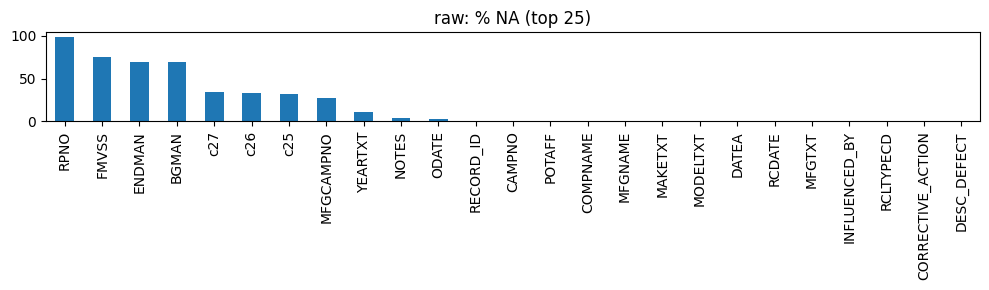

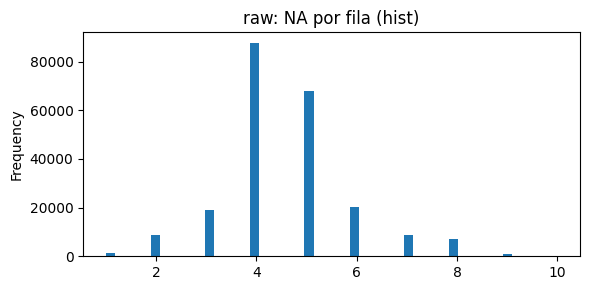

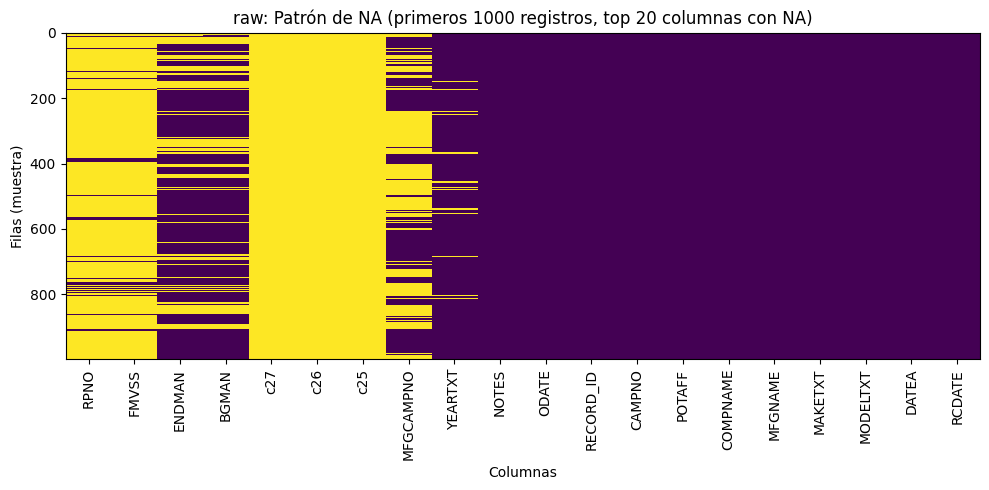


=== MISSING REPORT: camp ===
Shape: (14290, 18)
Numéricas: 6
Fechas   : 5
Categóricas: 7

Top columnas con más NA (%):


,NA_%
FMVSS,79.48
ENDMAN,41.55
BGMAN,41.47
YEARTXT,10.73
ODATE,2.19
CAMPNO,0.00
MFGNAME,0.00
COMPNAME,0.00
MODELTXT,0.00
RCLTYPECD,0.00



Distribución NA por fila (conteo de NA):


,count,mean,std,min,25%,50%,75%,max
0,14290.0,1.754234,1.127745,0.0,1.0,1.0,3.0,5.0


[OK] Guardado faltantes por columna -> /content/drive/MyDrive/Proyecto final/camp_na_by_col.csv
[OK] Guardado faltantes por fila    -> /content/drive/MyDrive/Proyecto final/camp_na_by_row.csv


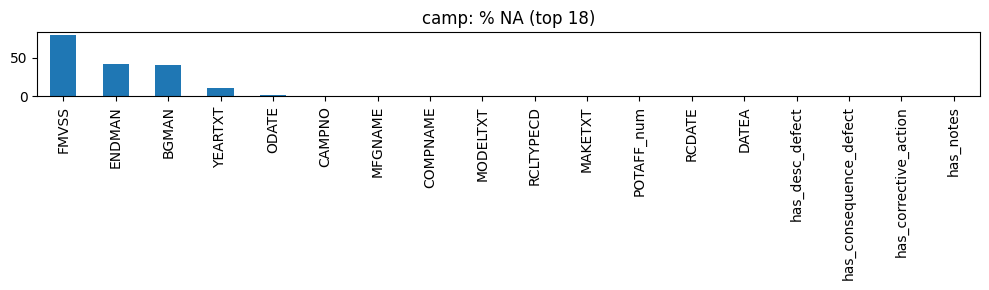

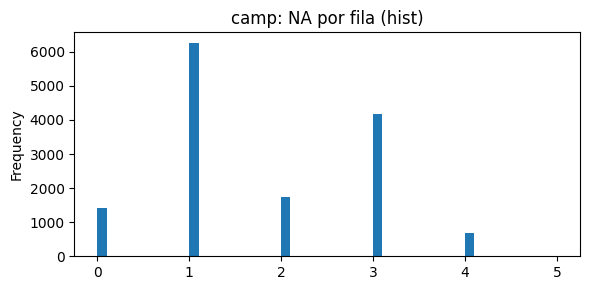

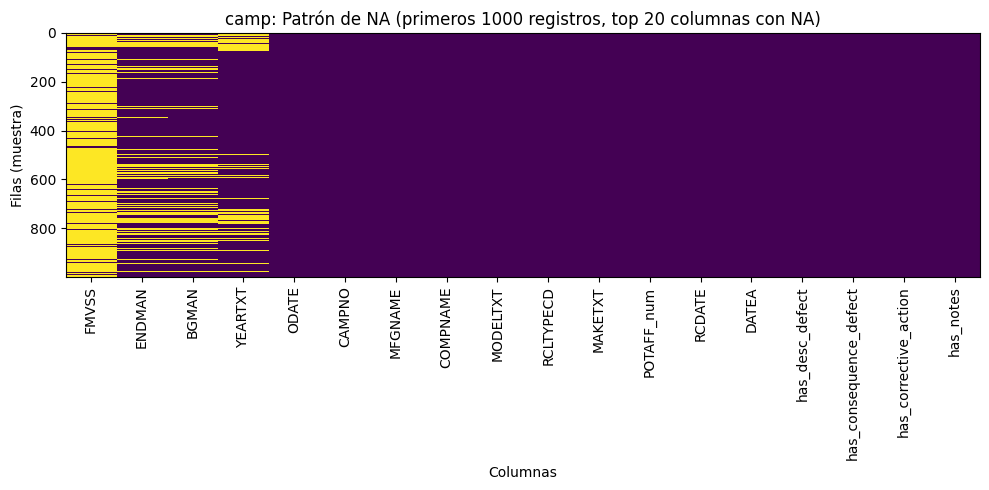


=== NA por grupo: camp ~ RCLTYPECD (top 10 columnas con más NA) ===


,FMVSS,ENDMAN,BGMAN,YEARTXT,ODATE,CAMPNO,MFGNAME,COMPNAME,MODELTXT,RCLTYPECD
RCLTYPECD,,,,,,,,,,
C,42.9,50.8,50.8,96.8,0.0,0.0,0.0,0.0,0.0,0.0
E,78.9,53.6,53.6,91.7,4.5,0.0,0.0,0.0,0.0,0.0
T,50.3,43.9,43.9,99.5,0.5,0.0,0.0,0.0,0.0,0.0
V,80.1,40.3,40.2,0.9,2.0,0.0,0.0,0.0,0.0,0.0



=== NA por grupo: camp ~ RCDATE_DECADE (top 10 columnas con más NA) ===


,FMVSS,ENDMAN,BGMAN,YEARTXT,ODATE,CAMPNO,MFGNAME,MAKETXT,COMPNAME,MODELTXT
RCDATE_DECADE,,,,,,,,,,
2010,81.3,12.0,11.8,11.0,1.0,0.0,0.0,0.0,0.0,0.0
2020,76.8,85.1,85.1,10.3,3.9,0.0,0.0,0.0,0.0,0.0



=== Co-ocurrencia de NA (camp) ===


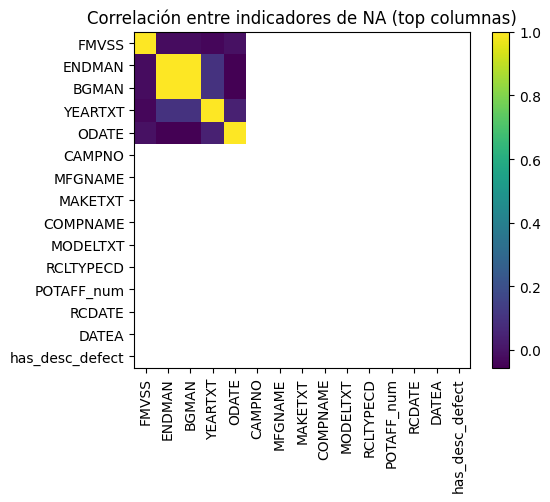


RCLTYPECD (legible):


,count
RCLTYPECD,
Vehicle,12765
Equipment,1275
Tire,187
Child Seat,63


In [19]:
# ==========================================
# Cargar CSV y análisis de faltantes avanzado
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

BASE = Path('/content/drive/MyDrive/Proyecto final')
RAW_CSV   = BASE / 'recalls_raw_enriched.csv'
CAMP_CSV  = BASE / 'recalls_by_campaign.csv'

# -------- 1) Carga robusta con tipos útiles --------
parse_dates = [c for c in ['ODATE','RCDATE','DATEA','BGMAN','ENDMAN']]

df_raw = pd.read_csv(RAW_CSV, low_memory=False, parse_dates=[c for c in parse_dates if c in pd.read_csv(RAW_CSV, nrows=1).columns])
df_camp = pd.read_csv(CAMP_CSV, low_memory=False, parse_dates=[c for c in parse_dates if c in pd.read_csv(CAMP_CSV, nrows=1).columns])

# YEARTXT como entero "nullable" si existe
for _df in (df_raw, df_camp):
    if 'YEARTXT' in _df.columns:
        _df['YEARTXT'] = pd.to_numeric(_df['YEARTXT'], errors='coerce').astype('Int64')
# POTAFF_num numérico (por si se pierde dtype al leer)
for _df in (df_raw, df_camp):
    if 'POTAFF_num' in _df.columns:
        _df['POTAFF_num'] = pd.to_numeric(_df['POTAFF_num'], errors='coerce')

print("RAW:", df_raw.shape, "| COLUMNS:", len(df_raw.columns))
print("CAMP:", df_camp.shape, "| COLUMNS:", len(df_camp.columns))

# -------- 2) Helpers para tipificar columnas por rol --------
def classify_columns(df):
    num_cols  = []
    date_cols = []
    cat_cols  = []
    for c in df.columns:
        if pd.api.types.is_numeric_dtype(df[c]):
            num_cols.append(c)
        elif pd.api.types.is_datetime64_any_dtype(df[c]):
            date_cols.append(c)
        else:
            cat_cols.append(c)
    return num_cols, date_cols, cat_cols

def missing_report(df, name="df", topk=30):
    print(f"\n=== MISSING REPORT: {name} ===")
    print("Shape:", df.shape)

    num_cols, date_cols, cat_cols = classify_columns(df)
    print("Numéricas:", len(num_cols))
    print("Fechas   :", len(date_cols))
    print("Categóricas:", len(cat_cols))

    # % faltantes por columna
    na_pct = df.isna().mean().sort_values(ascending=False)
    print("\nTop columnas con más NA (%):")
    display((na_pct.head(topk)*100).round(2).rename('NA_%'))

    # Resumen por filas
    row_na = df.isna().sum(axis=1)
    print("\nDistribución NA por fila (conteo de NA):")
    display(row_na.describe().to_frame().T)

    # Guardar CSV de faltantes
    out_cols = BASE / f'{name}_na_by_col.csv'
    out_rows = BASE / f'{name}_na_by_row.csv'
    na_pct.to_frame('na_frac').to_csv(out_cols)
    row_na.to_frame('na_count').to_csv(out_rows, index=True)
    print(f"[OK] Guardado faltantes por columna -> {out_cols}")
    print(f"[OK] Guardado faltantes por fila    -> {out_rows}")

    # Visuales: barras top-25 y distribución por filas
    k = min(25, len(na_pct))
    if k > 0:
        na_pct.head(k).mul(100).plot(kind='bar', figsize=(10,3), title=f'{name}: % NA (top {k})')
        plt.tight_layout(); plt.show()

    row_na.plot(kind='hist', bins=50, figsize=(6,3), title=f'{name}: NA por fila (hist)')
    plt.tight_layout(); plt.show()

    # Heatmap simple de patrones de NA (subset para no saturar)
    subset_cols = na_pct.head(20).index.tolist()
    n = min(1000, len(df))
    if subset_cols:
        plt.figure(figsize=(10,5))
        plt.imshow(df[subset_cols].isna().iloc[:n].values, aspect='auto', interpolation='nearest')
        plt.title(f'{name}: Patrón de NA (primeros {n} registros, top 20 columnas con NA)')
        plt.xlabel('Columnas'); plt.ylabel('Filas (muestra)')
        plt.xticks(ticks=np.arange(len(subset_cols)), labels=subset_cols, rotation=90)
        plt.tight_layout(); plt.show()

# -------- 3) Reporte de faltantes (raw y campaña) --------
missing_report(df_raw,  name='raw')
missing_report(df_camp, name='camp')

# -------- 4) Faltantes por grupos (para interpretar patrones) --------
def missing_by_group(df, group_col, name='df', topk_cols=10):
    if group_col not in df.columns:
        print(f"[skip] {group_col} no está en {name}")
        return
    na_pct = df.isna().mean().sort_values(ascending=False)
    focus = na_pct.head(topk_cols).index.tolist()
    if not focus:
        return
    print(f"\n=== NA por grupo: {name} ~ {group_col} (top {topk_cols} columnas con más NA) ===")
    grp = (df.groupby(group_col)[focus]
             .apply(lambda g: g.isna().mean()*100)
             .round(1))
    display(grp)

# Por tipo de producto (Vehicle/Equipment/Tire/Child seat)
missing_by_group(df_camp, 'RCLTYPECD', name='camp', topk_cols=10)

# Por década (según RCDATE)
def add_decade(df, date_col='RCDATE'):
    if date_col in df.columns:
        years = df[date_col].dt.year
        return (years // 10 * 10).astype('Int64')
    return pd.Series(pd.NA, index=df.index, dtype='Int64')

df_camp['RCDATE_DECADE'] = add_decade(df_camp, 'RCDATE')
missing_by_group(df_camp, 'RCDATE_DECADE', name='camp', topk_cols=10)

# -------- 5) Co-ocurrencia de faltantes (¿qué NA tienden a aparecer juntos?) --------
def missing_cooccurrence(df, topk=15):
    na_pct = df.isna().mean().sort_values(ascending=False)
    cols = na_pct.head(topk).index.tolist()
    if not cols:
        return None
    M = df[cols].isna().astype(int)
    # matriz de correlación de Pearson entre indicadores de NA
    corr = M.corr()
    # visualización simple
    plt.figure(figsize=(6,5))
    plt.imshow(corr.values, interpolation='nearest')
    plt.xticks(range(len(cols)), cols, rotation=90)
    plt.yticks(range(len(cols)), cols)
    plt.title('Correlación entre indicadores de NA (top columnas)')
    plt.colorbar()
    plt.tight_layout(); plt.show()
    return corr

print("\n=== Co-ocurrencia de NA (camp) ===")
na_corr_camp = missing_cooccurrence(df_camp, topk=15)

# -------- 6) Pequeño diccionario útil para informe --------
# Mapear RCLTYPECD a etiqueta legible
map_rcl = {'V':'Vehicle','E':'Equipment','T':'Tire','C':'Child Seat'}
if 'RCLTYPECD' in df_camp.columns:
    dist = df_camp['RCLTYPECD'].map(map_rcl).fillna(df_camp['RCLTYPECD']).value_counts(dropna=False)
    print("\nRCLTYPECD (legible):")
    display(dist)


En el **archivo crudo** (221,835 filas, 34 columnas) detectamos alta ausencia en variables regulatorias y de manufactura: `RPNO` (99.3%), `FMVSS` (75.3%) y ventanas de producción `BGMAN/ENDMAN` (\~69%); además, campos adicionales (`c25–c27`) presentan 32–34% de NA. En contraste, a **nivel campaña** (14,290 filas, 18 columnas) los faltantes bajan: persiste `FMVSS` (79.5%) y \~41% en `BGMAN/ENDMAN`, mientras que claves analíticas (`CAMPNO`, `MAKETXT`, `MFGNAME`, `COMPNAME`, `RCLTYPECD`, `POTAFF_num`, `RCDATE`) están completas. Por tipo de producto, `Vehicle` y `Equipment` carecen más de `FMVSS` (≈80% y 78.9%), y en **década** se observa que `BGMAN/ENDMAN` faltan mucho más en 2020s (≈85%) que en 2010s (~12%), reflejando menor disponibilidad reciente de ventanas de fabricación. La cobertura de texto es prácticamente total a nivel campaña (≥97.7%), útil para la fase NLP.


# Estadísticas rápidas

In [20]:
# ================================
# Estadísticas descriptivas (camp)
# ================================

# 1) Numéricas
num_cols = [c for c in ['YEARTXT','POTAFF_num'] if c in df_camp.columns]
if num_cols:
    display(df_camp[num_cols].describe(percentiles=[.01,.05,.5,.95,.99]))

# 2) Cardinalidad de categóricas
cat_cols = [c for c in ['MAKETXT','MODELTXT','COMPNAME','MFGNAME','RCLTYPECD','FMVSS','INFLUENCED_BY'] if c in df_camp.columns]
for c in cat_cols:
    print(f"{c}: {df_camp[c].nunique()} valores únicos")

# 3) Longitud de textos
for c in ['DESC_DEFECT','CONSEQUENCE_DEFECT','CORRECTIVE_ACTION','NOTES']:
    if c in df_camp.columns:
        df_camp[f'len_{c}'] = df_camp[c].fillna('').astype(str).str.len()
        print(f"{c:20s} mediana longitud: {df_camp[f'len_{c}'].median()}")


,YEARTXT,POTAFF_num
count,12756.0,1.429000e+04
mean,2017.42286,4.604573e+04
std,4.952215,3.077363e+05
min,1969.0,0.000000e+00
1%,2005.0,1.000000e+00
5%,2009.0,5.000000e+00
50%,2018.0,4.660000e+02
95%,2025.0,1.833637e+05
99%,2025.0,9.255669e+05
max,2027.0,1.760000e+07


MAKETXT: 1560 valores únicos
MODELTXT: 4865 valores únicos
COMPNAME: 589 valores únicos
MFGNAME: 1899 valores únicos
RCLTYPECD: 4 valores únicos
FMVSS: 65 valores únicos


Los descriptivos muestran que el campo **`YEARTXT`** (año de modelo) está bien concentrado en vehículos recientes: la mediana corresponde a 2018, con un 95% de los casos entre 2005 y 2025. El mínimo registrado es 1969 y el máximo 2027 (probablemente errores de captura o años estimados). En cuanto a **`POTAFF_num`** (unidades potencialmente afectadas por campaña), la distribución es muy sesgada: la mediana es de apenas 466 vehículos, pero el 5% superior de las campañas supera las 183 mil unidades y el máximo alcanza los 17.6 millones (casos emblemáticos como los airbags Takata). En variables categóricas, la base es muy diversa: **1560 marcas (`MAKETXT`)**, **4865 modelos (`MODELTXT`)**, **589 componentes (`COMPNAME`)** y **1899 fabricantes (`MFGNAME`)**. Por su parte, el tipo de campaña (`RCLTYPECD`) tiene solo 4 categorías (Vehicle, Equipment, Tire, Child Seat), y se registran **65 estándares de_**


# Outliers y distribuciones (univariante)

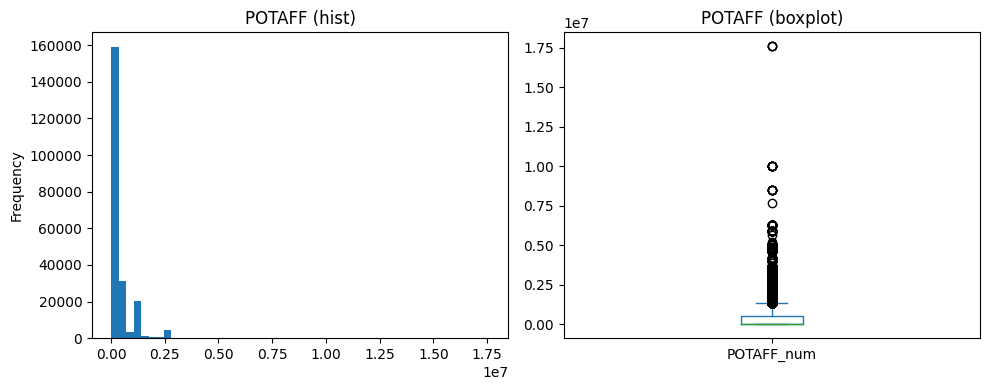

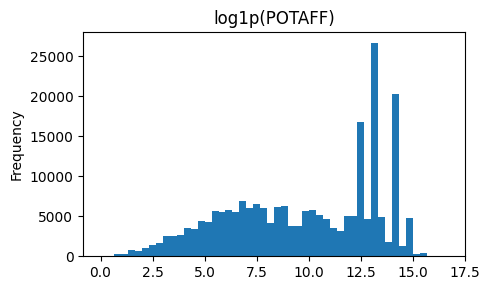

In [21]:
# Histograma y boxplot de POTAFF (si existe)
if 'POTAFF' in df.columns:
    df['POTAFF_num'] = pd.to_numeric(df['POTAFF'], errors='coerce')
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    df['POTAFF_num'].plot(kind='hist', bins=50, ax=ax[0]); ax[0].set_title('POTAFF (hist)')
    df['POTAFF_num'].plot(kind='box', ax=ax[1]); ax[1].set_title('POTAFF (boxplot)')
    plt.tight_layout(); plt.show()

    # Transformación sugerida (sesgo positivo)
    df['POTAFF_log1p'] = np.log1p(df['POTAFF_num'])
    df['POTAFF_log1p'].plot(kind='hist', bins=50, figsize=(5,3)); plt.title('log1p(POTAFF)'); plt.tight_layout(); plt.show()


POTAFF(Potencialmente afectados)
Histograma: La distribución original era fuertemente sesgada a la derecha, con la mayoría de los valores concentrados cerca de cero. Esto significa que la mayoría de los reportes afectaron a un número muy pequeño de personas/vehículos, mientras que unos pocos reportes tuvieron un impacto masivo.

Boxplot:reveló la presencia de numerosos valores atípicos que se alejan significativamente del resto de los datos. Estos valores extremos son los que causan el sesgo de la distribución y pueden distorsionar los resultados de modelos que asumen una distribución más normal.

# Tendencias temporales (si hay fechas)

/tmp/ipython-input-1036374185.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cnt_m = ts.resample('M').size()


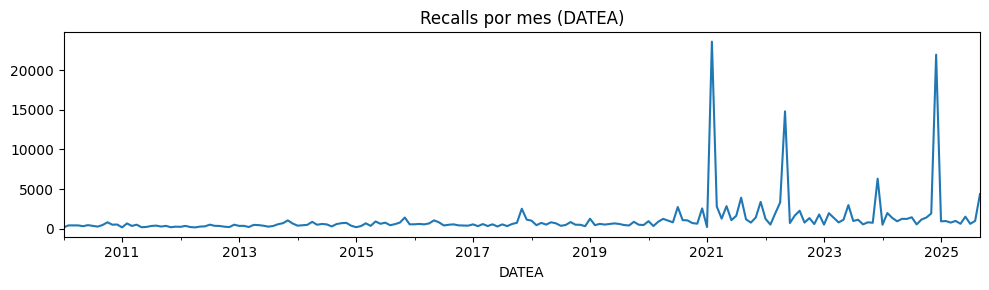

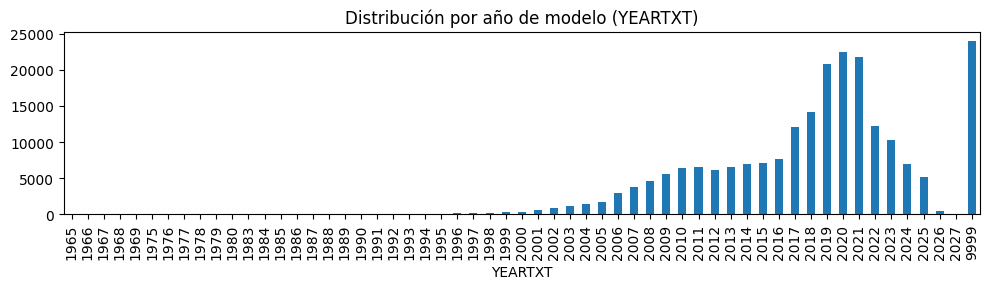

In [9]:
if 'DATEA' in df.columns:
    ts = df.set_index('DATEA').sort_index()
    # Conteo mensual
    cnt_m = ts.resample('M').size()
    cnt_m.plot(figsize=(10,3)); plt.title('Recalls por mes (DATEA)'); plt.tight_layout(); plt.show()

if 'YEARTXT' in df.columns:
    df['YEARTXT'].dropna().astype(int).value_counts().sort_index().plot(kind='bar', figsize=(10,3))
    plt.title('Distribución por año de modelo (YEARTXT)'); plt.tight_layout(); plt.show()


DATEA:Desde 2011 hasta principios de 2020, el número de reportes mensuales fue relativamente bajo y estable, con picos ocasionales. Se observan picos significativos a finales de 2020 y principios de 2021, después de estos picos, la frecuencia de los reportes se vuelve más volátil, con varios picos y valles a lo largo de 2022 y 2023, y otro pico notable en 2024. Podemos inferir que hubo un cambio una nueva regulación, una falla de producto generalizada o una política de la compañía, causó un incremento dramático en la cantidad de reportes.

YEARTXT: A partir de 2000, el número de reportes aumenta constantemente, con un crecimiento exponencial. La mayoría de los reportes corresponden a modelos de vehículos fabricados en la década de 2010 y, en particular, en la de 2020. Hay picos notables en 2018, 2019, 2020 y 2024, lo que sugiere que los vehículos más nuevos son los que tienen la mayor cantidad de retiros.

# Análisis bivariado (categorías × métrica)

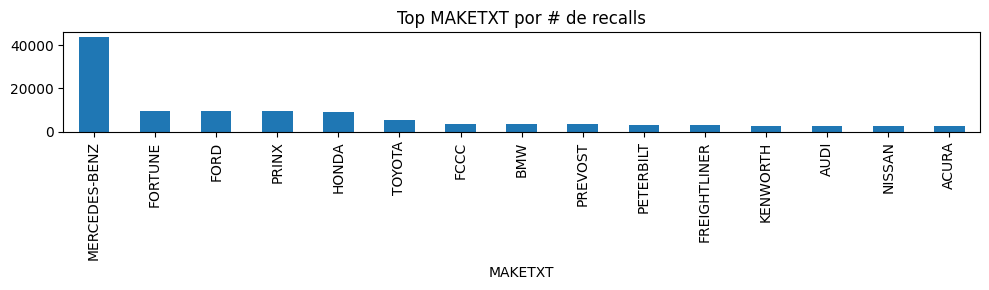

/tmp/ipython-input-204217484.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  top.plot(kind='bar', figsize=(10,3)); plt.title(f'Top {c} por # de recalls'); plt.tight_layout(); plt.show()


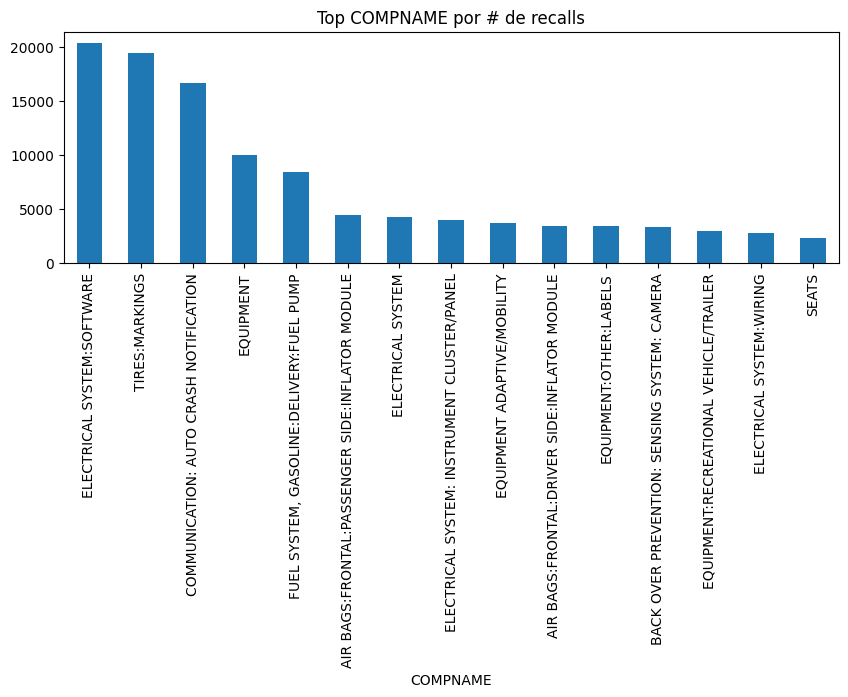

/tmp/ipython-input-204217484.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  top.plot(kind='bar', figsize=(10,3)); plt.title(f'Top {c} por # de recalls'); plt.tight_layout(); plt.show()


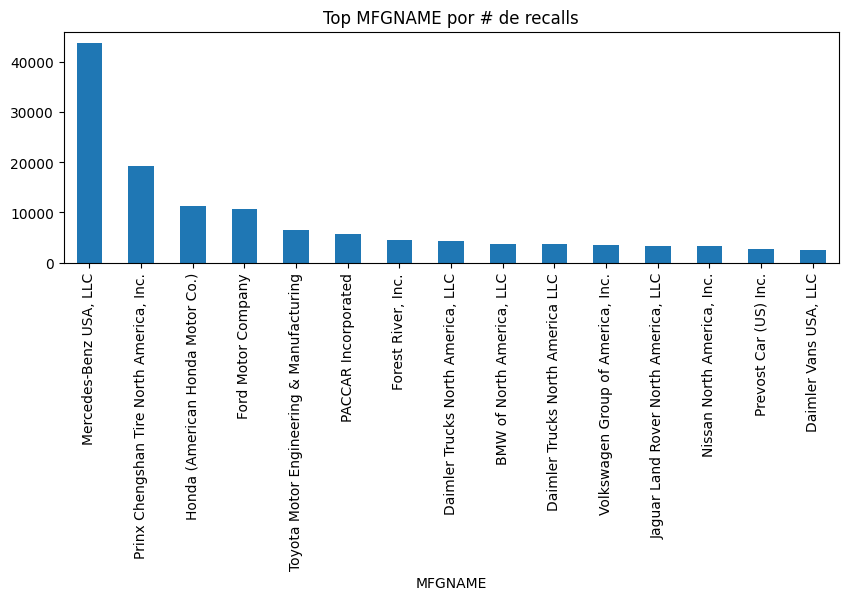

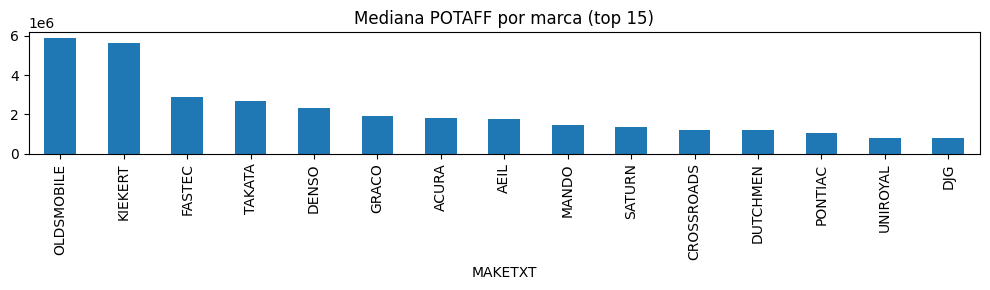

MAKETXT,3M,4 GUYS,4 STAR,4-STAR,4-STAR TRAILERS,4MOMS,A&J VANS,A&M,A.L. SOLUTIONS,A2ZEV,...,ZERO MOTORCYCLES INC.,ZF,ZF ELECTRONIC SYSTEMS,ZF GROUP,ZF NORTH AMERICA,ZIAMATIC CORP.,ZONE HELMETS,ZOOX,ZOX,Zoox
YEARTXT,,,,,,,,,,,,,,,,,,,,,
1965,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1968,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1969,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Top marcas y componentes por conteo
for c in ['MAKETXT','COMPNAME','MFGNAME']:
    if c in df.columns:
        top = df[c].value_counts().head(15)
        top.plot(kind='bar', figsize=(10,3)); plt.title(f'Top {c} por # de recalls'); plt.tight_layout(); plt.show()

# Promedio/mediana de POTAFF por marca (top 15)
if 'POTAFF_num' in df.columns and 'MAKETXT' in df.columns:
    grp = df.groupby('MAKETXT')['POTAFF_num'].median().sort_values(ascending=False).head(15)
    grp.plot(kind='bar', figsize=(10,3)); plt.title('Mediana POTAFF por marca (top 15)'); plt.tight_layout(); plt.show()

# Cruces por año-modelo (si no explota cardinalidad)
if {'YEARTXT','MAKETXT'}.issubset(df.columns):
    pivot = (df
             .dropna(subset=['YEARTXT','MAKETXT'])
             .assign(YEARTXT=df['YEARTXT'].astype('Int64'))
             .pivot_table(index='YEARTXT', columns='MAKETXT', values='RECORD_ID', aggfunc='count', fill_value=0))
    display(pivot.head())


El primer gráfico muestra el Top MAKETXT por número de retiros, nos permite identificar que Mercedes-Benz y Ford son las marcas con mayor retiro.

El segundo gráfico se centra en el Top COMPNAME por número de retiros, revelando los componentes que más fallas reportan:

Los sistemas eléctricos, los sistemas de seguridad (AIR BAGS:FRONTAL, COMMUNICATION:AUTO CRASH NOTIFICATION). También se destacan problemas en el sistema de combustible (FUEL SYSTEM, GASOLINE) y los neumáticos (TIRES:MARKINGS). Esto nos da una idea clara de las áreas de diseño o fabricación más vulnerables.

El tercer gráfico desglosa el Top MFGNAME por número de retiros y la Mediana POTAFF por marca, lo que nos da una visión tanto de los fabricantes (no solo las marcas) como de la magnitud del impacto de sus retiros.


1.   Mercedes-Benz USA es el fabricante con la mayor cantidad de retiros
2.   Otros fabricantes importantes incluyen Prinx Chengshan Tire North America y Honda.

El gráfico inferior, Mediana POTAFF por marca, revela las marcas que, en promedio, tienen los retiros que afectan al mayor número de vehículos. Oldsmobile y Kiekert lideran, con medianas de "Potencialmente Afectados" significativamente más altas que el resto.


In [11]:
num_for_corr = [c for c in ['YEARTXT','POTAFF_num','len_DESC_DEFECT','len_CONSEQUENCE_DEFECT','len_CORRECTIVE_ACTION'] if c in df.columns]
if num_for_corr:
    corr = df[num_for_corr].corr(numeric_only=True)
    print(corr)


                         YEARTXT  POTAFF_num  len_DESC_DEFECT  \
YEARTXT                 1.000000    0.078248         0.070445   
POTAFF_num              0.078248    1.000000         0.275280   
len_DESC_DEFECT         0.070445    0.275280         1.000000   
len_CONSEQUENCE_DEFECT -0.208243    0.032237         0.142771   
len_CORRECTIVE_ACTION  -0.252867    0.152840         0.191701   

                        len_CONSEQUENCE_DEFECT  len_CORRECTIVE_ACTION  
YEARTXT                              -0.208243              -0.252867  
POTAFF_num                            0.032237               0.152840  
len_DESC_DEFECT                       0.142771               0.191701  
len_CONSEQUENCE_DEFECT                1.000000               0.215682  
len_CORRECTIVE_ACTION                 0.215682               1.000000  


Text(0.5, 1.0, 'Mapa de Calor de Correlación')

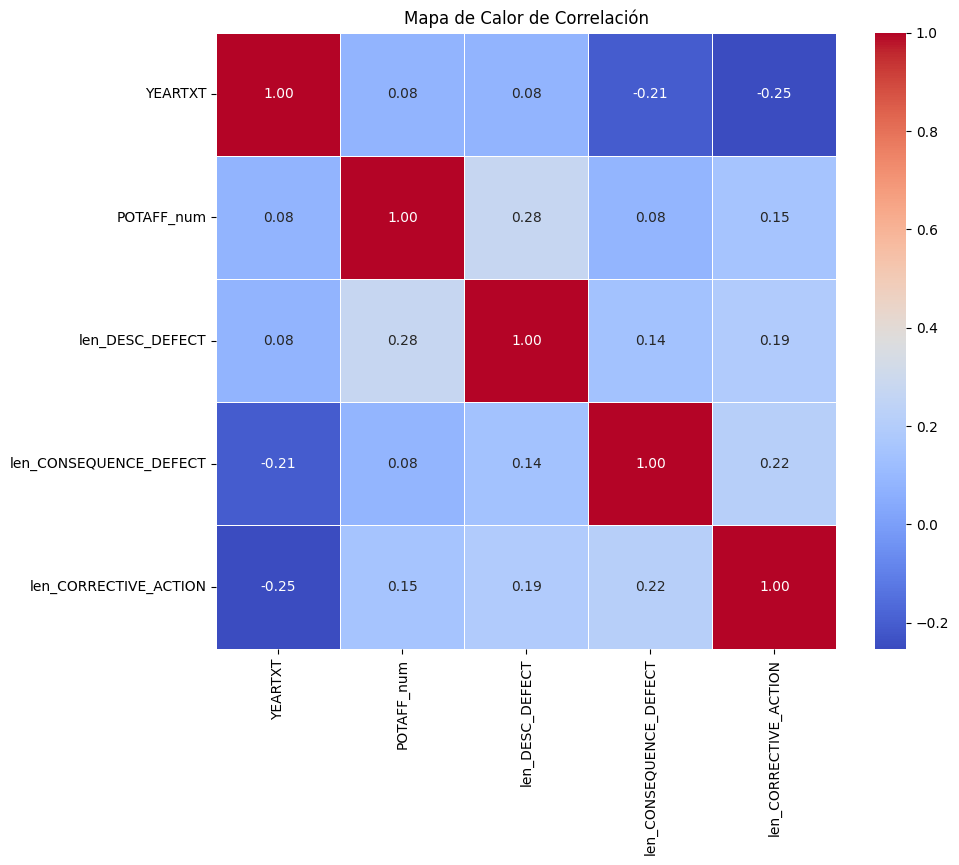

In [13]:
import seaborn as sns
# 1. Crear el DataFrame de correlación (reemplaza con tu tabla de correlación)
# Este es el código que necesitas para crear la matriz de correlación
data = {
    'YEARTXT': [1.000000, 0.078248, 0.078445, -0.208243, -0.252867],
    'POTAFF_num': [0.078248, 1.000000, 0.275280, 0.083237, 0.152848],
    'len_DESC_DEFECT': [0.078445, 0.275280, 1.000000, 0.142771, 0.191701],
    'len_CONSEQUENCE_DEFECT': [-0.208243, 0.083237, 0.142771, 1.000000, 0.215682],
    'len_CORRECTIVE_ACTION': [-0.252867, 0.152848, 0.191701, 0.215682, 1.000000]
}

corr_df = pd.DataFrame(data, index=list(data.keys()))

# 2. Configurar el tamaño del gráfico
plt.figure(figsize=(10, 8))

# 3. Generar el mapa de calor
# annot=True para mostrar los valores de correlación en el mapa
# cmap='coolwarm' para usar una paleta de colores que resalta las correlaciones positivas y negativas
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# 4. Añadir un título
plt.title('Mapa de Calor de Correlación')


<Axes: xlabel='POTAFF_num', ylabel='len_DESC_DEFECT'>

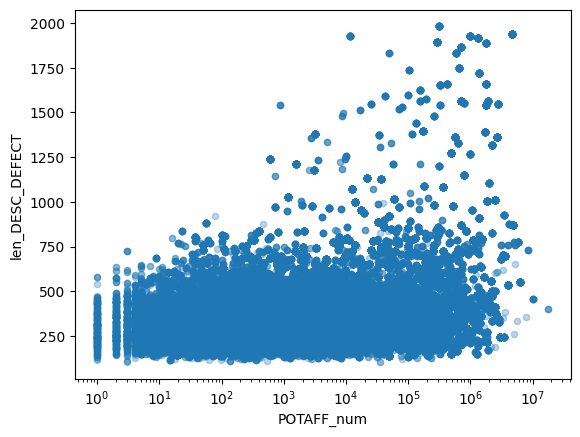

In [22]:
df.plot.scatter(x='POTAFF_num', y='len_DESC_DEFECT', alpha=0.3, logx=True)

### Interpretación de resultados hasta el momento

El análisis exploratorio de datos revela varios patrones importantes:

- **Distribución temporal (`YEARTXT`)**: la mayoría de las campañas corresponden a modelos de vehículos producidos entre 2005 y 2025, con una mediana en 2018. Existen valores mínimos de 1969 y máximos hasta 2027, que probablemente corresponden a errores o estimaciones de años de modelo.

- **Unidades afectadas (`POTAFF_num`)**: la variable presenta una fuerte asimetría positiva. La mediana de vehículos afectados por campaña es baja (≈466 unidades), pero unas pocas campañas masivas alcanzan millones de unidades, destacando casos emblemáticos como los airbags Takata. Esto confirma la presencia de outliers con gran impacto en la distribución.

- **Diversidad categórica**: la base de datos es muy heterogénea, con 1560 marcas, 4865 modelos, 589 tipos de componentes y 1899 fabricantes. Esto subraya el alcance amplio del conjunto de datos y la importancia de segmentar por fabricante, tipo de producto (`RCLTYPECD`: Vehicle, Equipment, Tire, Child Seat) o componente para análisis más precisos.

- **Componentes y fabricantes más recurrentes**: los gráficos iniciales muestran que sistemas eléctricos, bolsas de aire, sistemas de comunicación y neumáticos son los componentes con mayor número de retiros. Entre los fabricantes, Mercedes-Benz, Honda y Prinx Chengshan destacan en número de campañas.

- **Magnitud del impacto por marca**: al ordenar por mediana de `POTAFF_num`, aparecen marcas como Oldsmobile y Kiekert, cuyos recalls tienden a involucrar un número mucho mayor de unidades en comparación con otras.

- **Correlaciones**: aunque `YEARTXT` y `POTAFF_num` apenas se relacionan, se observa que campañas con más vehículos afectados tienden a tener descripciones más largas del defecto (`len_DESC_DEFECT`). Además, los recalls más recientes muestran descripciones algo más cortas, lo que podría reflejar cambios en el formato de reporte.

- **Visualización scatter POTAFF vs. longitud de descripciones**: el diagrama confirma que la mayoría de las campañas pequeñas mantienen textos de longitud estándar, mientras que las campañas masivas concentran descripciones más extensas. Esto sugiere que la magnitud de un recall se acompaña de un mayor nivel de detalle en la narrativa del defecto.

En conjunto, los resultados muestran un **conjunto de datos amplio, diverso y muy sesgado**, donde pocas campañas explican la mayor parte de las unidades afectadas. También apuntan a que el contenido textual de las campañas es una dimensión clave para comprender su alcance y características, lo que motiva un análisis posterior segmentado por tipo de producto, década y fabricante.


,campaigns,share_%
RCLTYPE,,
Vehicle,12765,89.33
Equipment,1275,8.92
Tire,187,1.31
Child Seat,63,0.44


,RCDATE_DECADE,RCLTYPE,campaigns
3,2010,Vehicle,7608
1,2010,Equipment,747
2,2010,Tire,117
0,2010,Child Seat,39
7,2020,Vehicle,5157
5,2020,Equipment,528
6,2020,Tire,70
4,2020,Child Seat,24


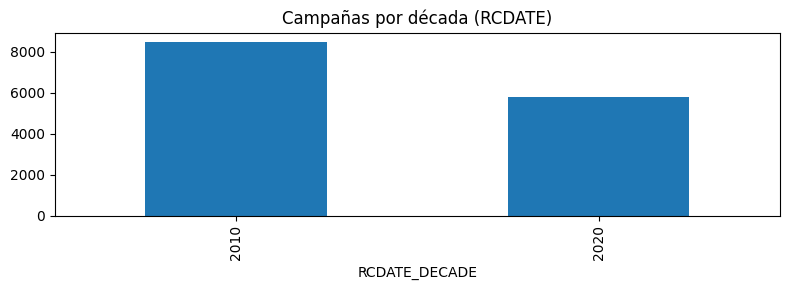

,campaigns
COMPNAME,
EQUIPMENT,842
EQUIPMENT:OTHER:LABELS,560
EQUIPMENT:RECREATIONAL VEHICLE/TRAILER,361
SEATS,291
ELECTRICAL SYSTEM,286
ELECTRICAL SYSTEM:WIRING,258
EQUIPMENT ADAPTIVE/MOBILITY,230
AIR BAGS:FRONTAL:PASSENGER SIDE:INFLATOR MODULE,198
STEERING,196


,median_potaff
COMPNAME,
CHILD SEAT:HARNESS/CROTCH BUCKLE,785497.5
ELECTRICAL SYSTEM:IGNITION:ANTI-THEFT:IMMOBILIZER/PROXIMITY:KEY/SENDER,712458.0
EXTERIOR LIGHTING:HEADLIGHTS:SWITCH,687958.0
CHILD SEAT:HARNESS:FRONT ADJUSTER BUTTON/RELEASE MECHANISM,608786.0
LATCHES/LOCKS/LINKAGES:TAILGATE:LATCH,401049.0
SUSPENSION:REAR:SPRINGS:LEAF SPRING ASSEMBLY:LEAF,355368.5
LATCHES/LOCKS/LINKAGES:TRUNK LID:LATCH,253074.0
ELECTRICAL SYSTEM:IGNITION:ANTI-THEFT:CONTROL MODULE,240242.0
POWER TRAIN:AUTOMATIC TRANSMISSION:FLUID/LUBRICANT:VALVES/VALVE BODY,231782.0


=== Consistency checks ===
campaigns_with_multiple_potaff_values      0.00
non_null_RCDATE_%                        100.00
non_null_ODATE_%                          97.81
non_null_DATEA_%                         100.00
dtype: float64
[OK] Guardados resúmenes en: /content/drive/MyDrive/Proyecto final/eda_grafo


In [23]:
# === Cierre de EDA orientado al grafo (Paso 1) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 0) Setup
OUT = Path('/content/drive/MyDrive/Proyecto final/eda_grafo')
OUT.mkdir(parents=True, exist_ok=True)

D = df_camp.copy()  # trabaja sobre copia para dejar rastro

# 1) Normalizaciones ligeras
map_rcl = {'V':'Vehicle','E':'Equipment','T':'Tire','C':'Child Seat'}
if 'RCLTYPECD' in D.columns:
    D['RCLTYPE'] = D['RCLTYPECD'].map(map_rcl).fillna(D.get('RCLTYPECD'))

for c in ['MFGNAME','MAKETXT']:
    if c in D.columns:
        D[c] = (D[c].astype(str).str.strip().str.replace(r'\s+', ' ', regex=True).str.upper())

# (No tocamos FMVSS; se mantiene tal cual para enlazar a catálogo)

# 2) Cobertura por tipo de producto
if 'RCLTYPE' in D.columns:
    cover_type = D['RCLTYPE'].value_counts(dropna=False).to_frame('campaigns')
    cover_type['share_%'] = (cover_type['campaigns']/len(D)*100).round(2)
    display(cover_type)
    cover_type.to_csv(OUT/'coverage_by_type.csv')

# 3) Tendencia por década (RCDATE)
def decade_from_date(s):
    y = s.dt.year
    return ((y//10)*10).astype('Int64')

if 'RCDATE' in D.columns:
    D['RCDATE_DECADE'] = decade_from_date(D['RCDATE'])
    trend_decade = (D.groupby(['RCDATE_DECADE','RCLTYPE'])
                      .size()
                      .rename('campaigns')
                      .reset_index()
                      .sort_values(['RCDATE_DECADE','campaigns'], ascending=[True, False]))
    display(trend_decade.head(20))
    trend_decade.to_csv(OUT/'trend_by_decade_type.csv', index=False)

    # Gráfico simple (campañas por década)
    (D.groupby('RCDATE_DECADE')
       .size()
       .plot(kind='bar', figsize=(8,3), title='Campañas por década (RCDATE)'))
    plt.tight_layout(); plt.show()

# 4) Top componentes:
# 4a) por número de campañas
if 'COMPNAME' in D.columns:
    top_comp_count = (D['COMPNAME'].value_counts()
                        .head(25)
                        .to_frame('campaigns'))
    display(top_comp_count.head(10))
    top_comp_count.to_csv(OUT/'top_components_by_count.csv')

# 4b) por mediana de POTAFF (requiere POTAFF_num)
if {'COMPNAME','POTAFF_num'}.issubset(D.columns):
    comp_median = (D.groupby('COMPNAME')['POTAFF_num']
                     .median()
                     .sort_values(ascending=False)
                     .head(25)
                     .to_frame('median_potaff'))
    display(comp_median.head(10))
    comp_median.to_csv(OUT/'top_components_by_median_potaff.csv')

# 5) Consistencia CAMPNO ↔ POTAFF / fechas
checks = {}

# 5a) POTAFF único por campaña
if {'CAMPNO','POTAFF_num'}.issubset(df_camp.columns):
    potaff_var_per_camp = (df_camp.groupby('CAMPNO')['POTAFF_num']
                           .agg(lambda s: pd.Series(s.unique()).size))
    checks['campaigns_with_multiple_potaff_values'] = int((potaff_var_per_camp > 1).sum())

# 5b) Fechas parseadas (porcentaje no nulo)
for col in ['RCDATE','ODATE','DATEA']:
    if col in D.columns:
        checks[f'non_null_{col}_%'] = round(D[col].notna().mean()*100, 2)

pd.Series(checks).to_csv(OUT/'consistency_checks.csv')
print("=== Consistency checks ===")
print(pd.Series(checks))

# 6) Persistir el dataframe normalizado (opcional, para siguientes pasos)
df_camp_norm = D.copy()
df_camp_norm.to_csv(OUT/'df_camp_normalized_snapshot.csv', index=False)
print(f"[OK] Guardados resúmenes en: {OUT}")


### Distribución por tipo de producto

* **Vehicle domina (89.3%)**, seguido por **Equipment (8.9%)**, **Tire (1.3%)** y **Child Seat (0.44%)**.
  ➜ Para la **v1 del grafo**, prioriza el subgrafo *Vehicle* y deja *Equipment/Tire/Child Seat* como capas adicionales.

### Tendencias por década (RCDATE)

* **2010s:** 7,608 campañas *Vehicle* (pico histórico) y actividad notable en *Equipment* (747).
* **2020s:** cae el conteo (5,157 *Vehicle*), pero se mantiene un volumen significativo.
  ➜ Conviene indexar campañas por **década** (propiedad en `Campaign`) para consultas temporales y dashboards.

### Componentes — frecuencia vs. impacto

* **Más frecuentes (por # campañas):** muchas etiquetas genéricas de *Equipment* (p. ej. `EQUIPMENT`, `OTHER:LABELS`, `RV/TRAILER`) y sistemas base (`SEATS`, `ELECTRICAL SYSTEM`, `STEERING`).
* **Mayor impacto típico (mediana POTAFF):** sobresalen **Child Seat** (arnés/broches) y **eléctrica/encendido/antirrobo**, además de **latches/locks**, **suspensión trasera (leaf springs)** y **transmisión (valve body)**.
  ➜ En la ontología de **Component**, crea jerarquías:
  `System > Subsystem > Part` (p. ej., *Electrical System > Ignition > Anti-theft > Module/Key/Sender*).
  ➜ Distingue **frecuencia** (riesgo de recurrencia) de **impacto** (POTAFF mediano). Ambos ejes son útiles para priorizar.

### Calidad de datos (consistencia)

* **POTAFF único por campaña: 0 inconsistencias** ✅
* **Fechas presentes:** `RCDATE`/`DATEA` ~100%, `ODATE` ~97.8% ✅
  ➜ Listo para usar `RCDATE` como eje temporal del grafo; `ODATE` como fecha de notificación cuando exista.

---

#### Implicaciones para construir el grafo (paso inmediato)

1. **Nodos prioritarios:** `Campaign`, `Manufacturer`, `Make`, `Model`, `ModelYear`, `Component`, `Standard`.
2. **Aristas:** `FILED_BY`, `AFFECTS`/`AFFECTS_MODEL`/`AFFECTS_YEAR`, `INVOLVES`, `REFERENCES`.
3. **Normaliza `Component`** (merge de sinónimos y desambiguación de etiquetas muy genéricas de *Equipment*).
4. **Añade propiedades útiles a `Campaign`:** `decade`, `potAff`, `rclType`.
5. **Define dos “vistas” analíticas en el KG:**

   * **Recurrencia:** top componentes por #campañas.
   * **Impacto:** top componentes por mediana `potAff`.

In [24]:
# ============================================
# Normalización ligera para el grafo (reversible)
# - Mantiene columnas originales y crea *_CANON
# - Estandariza RCLTYPE, MFG/MAKE, y COMPONENTE (jerarquía)
# - Guarda mapeos y snapshot normalizado
# ============================================
import re
import pandas as pd
from pathlib import Path

# 0) Selección del dataframe fuente
D = None
if 'df_camp_norm' in globals():
    D = df_camp_norm.copy()
elif 'df_camp' in globals():
    D = df_camp.copy()
else:
    raise RuntimeError("No encuentro df_camp ni df_camp_norm en el entorno.")

OUT = Path('/content/drive/MyDrive/Proyecto final/norm')
OUT.mkdir(parents=True, exist_ok=True)

# 1) Map de tipo de producto
map_rcl = {'V':'Vehicle','E':'Equipment','T':'Tire','C':'Child Seat'}
if 'RCLTYPECD' in D.columns:
    D['RCLTYPE'] = D['RCLTYPECD'].map(map_rcl).fillna(D.get('RCLTYPECD'))

# 2) Normalización de fabricantes y marcas (conservadora)
SUFFIXES = r'\b(CORP(ORATION)?|COMPANY|CO\.?|INC\.?|LLC|L\.P\.?|LTD\.?|GMBH|S\.A\.|S\.A\. DE C\.V\.|S\.R\.L\.)\b'
def normalize_company(x: str) -> str:
    if not isinstance(x, str): return x
    s = x.upper().strip()
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(SUFFIXES, '', s)
    s = re.sub(r'[.,;:/\-]+', ' ', s)       # punt/símbolos suaves
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def normalize_make(x: str) -> str:
    if not isinstance(x, str): return x
    s = x.upper().strip()
    s = re.sub(r'\s+', ' ', s)
    return s

for col, fn in [('MFGNAME','normalize_company'), ('MAKETXT','normalize_make')]:
    if col in D.columns:
        D[col + '_CANON'] = eval(fn)(D[col]) if hasattr(D[col], 'map') else D[col]

# 3) Normalización de FMVSS (opcional: extraer número principal)
if 'FMVSS' in D.columns:
    def fmvss_main(x):
        if pd.isna(x): return x
        m = re.search(r'(\d{2,3})', str(x))
        return m.group(1) if m else x
    D['FMVSS_MAIN'] = D['FMVSS'].map(fmvss_main)

# 4) Normalización de componentes (jerarquía)
#    - Reglas regex de ejemplo (amplíalas conforme veas tu data)
COMP_RULES = [
    # (pattern, SYSTEM, SUBSYSTEM, PART, canonical_name)
    (r'^EQUIPMENT(\b|:|$)',                    'Equipment',    'General/Other',    None,                            'EQUIPMENT'),
    (r'^EQUIPMENT:OTHER:LABELS',               'Equipment',    'Labels',          None,                            'EQUIPMENT:OTHER:LABELS'),
    (r'^EQUIPMENT:RECREATIONAL VEHICLE/TRAILER','Equipment',   'RV/Trailer',      None,                            'EQUIPMENT:RECREATIONAL VEHICLE/TRAILER'),
    (r'^ELECTRICAL SYSTEM(:|$)',               'Electrical',   'General',         None,                            'ELECTRICAL SYSTEM'),
    (r'^ELECTRICAL SYSTEM:WIRING',             'Electrical',   'Wiring',          None,                            'ELECTRICAL SYSTEM:WIRING'),
    (r'^AIR BAGS(:|$)',                        'Safety',       'Airbags',         None,                            'AIR BAGS'),
    (r'^AIR BAGS:FRONTAL:PASSENGER SIDE:INFLATOR MODULE','Safety','Airbags','Frontal Passenger Inflator','AIR BAGS:FRONTAL:PASSENGER SIDE:INFLATOR MODULE'),
    (r'^AIR BAGS:FRONTAL:DRIVER SIDE:INFLATOR MODULE','Safety','Airbags','Frontal Driver Inflator','AIR BAGS:FRONTAL:DRIVER SIDE:INFLATOR MODULE'),
    (r'^STEERING\b',                           'Chassis',      'Steering',        None,                            'STEERING'),
    (r'^SEATS\b',                              'Body/Interior','Seats',           None,                            'SEATS'),
    (r'^STRUCTURE\b',                          'Body/Exterior','Structure',       None,                            'STRUCTURE'),
    (r'^TIRES(:|$)|^TIRE(:|$)',                'Tires',        'General',         None,                            'TIRES'),
    (r'^EXTERIOR LIGHTING:HEADLIGHTS:SWITCH',  'Electrical',   'Lighting',        'Headlight Switch',              'EXTERIOR LIGHTING:HEADLIGHTS:SWITCH'),
    (r'^POWER TRAIN:AUTOMATIC TRANSMISSION:FLUID/LUBRICANT:VALVES/VALVE BODY','Powertrain','AT','Valve Body','POWER TRAIN:AUTOMATIC TRANSMISSION:FLUID/LUBRICANT:VALVES/VALVE BODY'),
    (r'^LATCHES/LOCKS/LINKAGES:TRUNK LID:LATCH','Body/Exterior','Latches/Locks','Trunk Latch','LATCHES/LOCKS/LINKAGES:TRUNK LID:LATCH'),
    (r'^LATCHES/LOCKS/LINKAGES:TAILGATE:LATCH','Body/Exterior','Latches/Locks','Tailgate Latch','LATCHES/LOCKS/LINKAGES:TAILGATE:LATCH'),
    (r'^SUSPENSION:REAR:SPRINGS:LEAF SPRING ASSEMBLY:LEAF','Chassis','Suspension','Rear Leaf Spring','SUSPENSION:REAR:SPRINGS:LEAF SPRING ASSEMBLY:LEAF'),
    (r'^ELECTRICAL SYSTEM:IGNITION:ANTI-THEFT:IMMOBILIZER/PROXIMITY:KEY/SENDER','Electrical','Ignition/Anti-theft','Key/Sender','ELECTRICAL SYSTEM:IGNITION:ANTI-THEFT:IMMOBILIZER/PROXIMITY:KEY/SENDER'),
    (r'^ELECTRICAL SYSTEM:IGNITION:ANTI-THEFT:CONTROL MODULE','Electrical','Ignition/Anti-theft','Control Module','ELECTRICAL SYSTEM:IGNITION:ANTI-THEFT:CONTROL MODULE'),
    (r'^CHILD SEAT:HARNESS/CROTCH BUCKLE',     'Child Seat',   'Harness',         'Crotch Buckle',                 'CHILD SEAT:HARNESS/CROTCH BUCKLE'),
    (r'^CHILD SEAT:HARNESS:FRONT ADJUSTER BUTTON/RELEASE MECHANISM','Child Seat','Harness','Front Adjuster','CHILD SEAT:HARNESS:FRONT ADJUSTER BUTTON/RELEASE MECHANISM'),
    (r'^CHILD SEAT:HARNESS RETAINER/CHEST CLIP','Child Seat',  'Harness',         'Chest Clip',                    'CHILD SEAT:HARNESS RETAINER/CHEST CLIP'),
]

def normalize_component(name: str):
    if not isinstance(name, str) or not name.strip():
        return pd.Series([name, None, None, None, name], index=['COMPNAME_CANON','COMP_SYSTEM','COMP_SUBSYSTEM','COMP_PART','COMPNAME_ORIG'])
    s = name.strip().upper()
    for pat, sys, subsys, part, canon in COMP_RULES:
        if re.search(pat, s, flags=re.IGNORECASE):
            return pd.Series([canon, sys, subsys, part, name], index=['COMPNAME_CANON','COMP_SYSTEM','COMP_SUBSYSTEM','COMP_PART','COMPNAME_ORIG'])
    # fallback genérico: separar por ':' en hasta 3 niveles
    toks = [t.strip() for t in s.split(':')]
    sys  = toks[0] if len(toks) > 0 else None
    subs = toks[1] if len(toks) > 1 else None
    part = toks[2] if len(toks) > 2 else None
    return pd.Series([s, sys, subs, part, name], index=['COMPNAME_CANON','COMP_SYSTEM','COMP_SUBSYSTEM','COMP_PART','COMPNAME_ORIG'])

if 'COMPNAME' in D.columns:
    comp_norm = D['COMPNAME'].apply(normalize_component)
    D = pd.concat([D, comp_norm], axis=1)

# 5) Auditoría de reducción (cuántos distintos antes vs. después)
audit = {}
if 'MFGNAME' in D.columns:
    audit['MFGNAME_unique_before']  = D['MFGNAME'].nunique(dropna=True)
    audit['MFGNAME_unique_after']   = D['MFGNAME_CANON'].nunique(dropna=True)
if 'MAKETXT' in D.columns:
    audit['MAKETXT_unique_before']  = D['MAKETXT'].nunique(dropna=True)
    audit['MAKETXT_unique_after']   = D['MAKETXT_CANON'].nunique(dropna=True)
if 'COMPNAME' in D.columns:
    audit['COMPNAME_unique_before'] = D['COMPNAME'].nunique(dropna=True)
    audit['COMPNAME_unique_after']  = D['COMPNAME_CANON'].nunique(dropna=True)

print("=== Auditoría de normalización (conteos únicos) ===")
for k,v in audit.items():
    print(f"{k:28s}: {v}")

# 6) Guardar mapeos y snapshot
#    - Mapeo fabricante/marca original->canónico
maps = []
if 'MFGNAME' in D.columns:
    maps.append(D[['MFGNAME','MFGNAME_CANON']].drop_duplicates().rename(columns={'MFGNAME':'orig','MFGNAME_CANON':'canon'}).assign(field='MFGNAME'))
if 'MAKETXT' in D.columns:
    maps.append(D[['MAKETXT','MAKETXT_CANON']].drop_duplicates().rename(columns={'MAKETXT':'orig','MAKETXT_CANON':'canon'}).assign(field='MAKETXT'))
if 'COMPNAME' in D.columns:
    maps.append(D[['COMPNAME','COMPNAME_CANON','COMP_SYSTEM','COMP_SUBSYSTEM','COMP_PART']].drop_duplicates().rename(columns={'COMPNAME':'orig'}).assign(field='COMPNAME'))
if maps:
    mapping_df = pd.concat(maps, ignore_index=True)
    mapping_df.to_csv(OUT/'normalization_mappings.csv', index=False)

D.to_csv(OUT/'df_camp_normalized_final.csv', index=False)

print(f"[OK] Snapshot normalizado -> {OUT/'df_camp_normalized_final.csv'}")
print(f"[OK] Mapeos de normalización -> {OUT/'normalization_mappings.csv'}")

# 7) Vista rápida: top-15 componentes canónicos por campañas
if 'COMPNAME_CANON' in D.columns:
    top_can = D['COMPNAME_CANON'].value_counts().head(15)
    print("\nTop 15 COMPNAME_CANON por # campañas:")
    display(top_can.to_frame('campaigns'))


=== Auditoría de normalización (conteos únicos) ===
MFGNAME_unique_before       : 1678
MFGNAME_unique_after        : 1678
MAKETXT_unique_before       : 1557
MAKETXT_unique_after        : 1557
COMPNAME_unique_before      : 589
COMPNAME_unique_after       : 356
[OK] Snapshot normalizado -> /content/drive/MyDrive/Proyecto final/norm/df_camp_normalized_final.csv
[OK] Mapeos de normalización -> /content/drive/MyDrive/Proyecto final/norm/normalization_mappings.csv

Top 15 COMPNAME_CANON por # campañas:


,campaigns
COMPNAME_CANON,
EQUIPMENT,2880
ELECTRICAL SYSTEM,1611
STRUCTURE,830
AIR BAGS,817
STEERING,682
SEATS,446
TIRES,411
EXTERIOR LIGHTING,157
EXTERIOR LIGHTING:HEADLIGHTS,133


In [25]:
# ============================================
# Exportar nodos y aristas (versión canónica)
# + Mini-QC de grados
# ============================================
import pandas as pd
from pathlib import Path
import numpy as np
import re

# --- 0) Carga robusta del snapshot normalizado (o usa D si ya existe) ---
NORM_DIR = Path('/content/drive/MyDrive/Proyecto final/norm')
NORM_CSV = NORM_DIR / 'df_camp_normalized_final.csv'

if 'D' in globals() and isinstance(D, pd.DataFrame):
    dfN = D.copy()
elif 'df_camp_norm' in globals():
    dfN = df_camp_norm.copy()
else:
    dfN = pd.read_csv(NORM_CSV, low_memory=False, parse_dates=[c for c in ['RCDATE','ODATE','DATEA','BGMAN','ENDMAN'] if c in pd.read_csv(NORM_CSV, nrows=1).columns])

# Asegurar tipos útiles
if 'POTAFF_num' in dfN.columns:
    dfN['POTAFF_num'] = pd.to_numeric(dfN['POTAFF_num'], errors='coerce')
if 'YEARTXT' in dfN.columns:
    dfN['YEARTXT'] = pd.to_numeric(dfN['YEARTXT'], errors='coerce').astype('Int64')

# Columna de tipo legible (ya generada previamente)
if 'RCLTYPE' not in dfN.columns and 'RCLTYPECD' in dfN.columns:
    map_rcl = {'V':'Vehicle','E':'Equipment','T':'Tire','C':'Child Seat'}
    dfN['RCLTYPE'] = dfN['RCLTYPECD'].map(map_rcl).fillna(dfN.get('RCLTYPECD'))

# --- 1) Directorio de exportación ---
OUT = Path('/content/drive/MyDrive/Proyecto final/kg_exports')
OUT.mkdir(parents=True, exist_ok=True)

# --- 2) Helpers de unicidad limpias ---
def uniq_series(s):
    return (s.dropna().astype(str).str.strip().loc[lambda x: x!=''].drop_duplicates())

def clean_spaces(s):
    return (s.astype(str).str.strip().str.replace(r'\s+', ' ', regex=True))

# --- 3) NODOS (canónicos cuando existan) ---
# Campaign
nodes_campaign = dfN[['CAMPNO','POTAFF_num','RCDATE','RCLTYPE']].drop_duplicates()
nodes_campaign = nodes_campaign.rename(columns={'CAMPNO':'camId','POTAFF_num':'potAff','RCDATE':'rcdDate','RCLTYPE':'rclType'})

# Manufacturer (usa canónico si existe)
man_col = 'MFGNAME_CANON' if 'MFGNAME_CANON' in dfN.columns else 'MFGNAME'
nodes_manufacturer = uniq_series(clean_spaces(dfN[man_col])).to_frame('name')

# Make (usa canónico si existe)
make_col = 'MAKETXT_CANON' if 'MAKETXT_CANON' in dfN.columns else 'MAKETXT'
nodes_make = uniq_series(clean_spaces(dfN[make_col])).to_frame('name')

# Model (normaliza suave a mayúsculas + espacios)
if 'MODELTXT' in dfN.columns:
    nodes_model = uniq_series(clean_spaces(dfN['MODELTXT']).str.upper()).to_frame('name')
else:
    nodes_model = pd.DataFrame(columns=['name'])

# Component (usa canónico + jerarquía)
comp_base = []
if 'COMPNAME_CANON' in dfN.columns:
    comp_base = ['COMPNAME_CANON','COMP_SYSTEM','COMP_SUBSYSTEM','COMP_PART']
    nodes_component = (dfN[comp_base]
                       .dropna(subset=['COMPNAME_CANON'])
                       .drop_duplicates()
                       .rename(columns={'COMPNAME_CANON':'name',
                                        'COMP_SYSTEM':'system',
                                        'COMP_SUBSYSTEM':'subsystem',
                                        'COMP_PART':'part'}))
else:
    nodes_component = uniq_series(clean_spaces(dfN['COMPNAME'])).to_frame('name') if 'COMPNAME' in dfN.columns else pd.DataFrame(columns=['name'])

# Standard (FMVSS)
std_cols = []
if 'FMVSS_MAIN' in dfN.columns:
    std_cols = ['FMVSS','FMVSS_MAIN']
    nodes_standard = (dfN[std_cols].dropna(subset=['FMVSS']).drop_duplicates()
                      .rename(columns={'FMVSS':'code','FMVSS_MAIN':'main'}))
elif 'FMVSS' in dfN.columns:
    nodes_standard = uniq_series(clean_spaces(dfN['FMVSS'])).to_frame('code')
else:
    nodes_standard = pd.DataFrame(columns=['code'])

# ModelYear
nodes_year = dfN['YEARTXT'].dropna().drop_duplicates().to_frame('year')

# --- 4) ARISTAS (usa canónicos cuando existan) ---
edges = {}

# FILED_BY
if {'CAMPNO', man_col}.issubset(dfN.columns):
    edges['FILED_BY'] = (dfN[['CAMPNO', man_col]]
                         .dropna().drop_duplicates()
                         .rename(columns={'CAMPNO':'camId', man_col:'name'}))

# AFFECTS (Make)
if {'CAMPNO', make_col}.issubset(dfN.columns):
    edges['AFFECTS'] = (dfN[['CAMPNO', make_col]]
                        .dropna().drop_duplicates()
                        .rename(columns={'CAMPNO':'camId', make_col:'name'}))

# AFFECTS_MODEL
if {'CAMPNO','MODELTXT'}.issubset(dfN.columns):
    tmp = dfN[['CAMPNO','MODELTXT']].dropna().drop_duplicates()
    tmp['MODELTXT'] = clean_spaces(tmp['MODELTXT']).str.upper()
    edges['AFFECTS_MODEL'] = tmp.rename(columns={'CAMPNO':'camId','MODELTXT':'name'})

# AFFECTS_YEAR
if {'CAMPNO','YEARTXT'}.issubset(dfN.columns):
    edges['AFFECTS_YEAR'] = (dfN[['CAMPNO','YEARTXT']]
                             .dropna().drop_duplicates()
                             .rename(columns={'CAMPNO':'camId','YEARTXT':'year'}))

# INVOLVES (Component)
if 'COMPNAME_CANON' in dfN.columns and {'CAMPNO','COMPNAME_CANON'}.issubset(dfN.columns):
    edges['INVOLVES'] = (dfN[['CAMPNO','COMPNAME_CANON']]
                         .dropna().drop_duplicates()
                         .rename(columns={'CAMPNO':'camId','COMPNAME_CANON':'name'}))
elif {'CAMPNO','COMPNAME'}.issubset(dfN.columns):
    edges['INVOLVES'] = (dfN[['CAMPNO','COMPNAME']]
                         .dropna().drop_duplicates()
                         .rename(columns={'CAMPNO':'camId','COMPNAME':'name'}))

# REFERENCES (Standard)
if {'CAMPNO','FMVSS'}.issubset(dfN.columns):
    edges['REFERENCES'] = (dfN[['CAMPNO','FMVSS']]
                           .dropna().drop_duplicates()
                           .rename(columns={'CAMPNO':'camId','FMVSS':'code'}))

# --- 5) Guardado de CSVs ---
nodes_campaign.to_csv(OUT/'nodes_campaign.csv', index=False)
nodes_manufacturer.to_csv(OUT/'nodes_manufacturer.csv', index=False)
nodes_make.to_csv(OUT/'nodes_make.csv', index=False)
nodes_model.to_csv(OUT/'nodes_model.csv', index=False)
nodes_component.to_csv(OUT/'nodes_component.csv', index=False)
nodes_standard.to_csv(OUT/'nodes_standard.csv', index=False)
nodes_year.to_csv(OUT/'nodes_year.csv', index=False)

for rel, df_rel in edges.items():
    df_rel.to_csv(OUT/f'edges_{rel.lower()}.csv', index=False)

print("[OK] Exportados nodos y aristas a:", OUT)

# --- 6) Mini-QC de grados esperados (sin Neo4j todavía) ---
qc = {}

# Grado de fabricantes (cuántas campañas por fabricante)
if not nodes_manufacturer.empty and 'FILED_BY' in edges:
    deg_mfg = edges['FILED_BY']['name'].value_counts()
    qc['manufacturers'] = len(deg_mfg)
    qc['mfg_top5'] = deg_mfg.head(5).to_dict()

# Grado de componentes (cuántas campañas por componente canónico)
if not nodes_component.empty and 'INVOLVES' in edges:
    deg_comp = edges['INVOLVES']['name'].value_counts()
    qc['components'] = len(deg_comp)
    qc['comp_top5'] = deg_comp.head(5).to_dict()

# Grado de make (cuántas campañas por marca)
if not nodes_make.empty and 'AFFECTS' in edges:
    deg_make = edges['AFFECTS']['name'].value_counts()
    qc['makes'] = len(deg_make)
    qc['make_top5'] = deg_make.head(5).to_dict()

# Año de modelo (cuántas campañas por año)
if not nodes_year.empty and 'AFFECTS_YEAR' in edges:
    deg_year = edges['AFFECTS_YEAR']['year'].value_counts().sort_index()
    qc['years'] = int(deg_year.size)
    qc['year_min'] = int(deg_year.index.min())
    qc['year_max'] = int(deg_year.index.max())
    qc['year_top5'] = deg_year.sort_values(ascending=False).head(5).to_dict()

print("\n=== MINI-QC (grados y rangos) ===")
for k,v in qc.items():
    print(f"{k}: {v}")


[OK] Exportados nodos y aristas a: /content/drive/MyDrive/Proyecto final/kg_exports

=== MINI-QC (grados y rangos) ===
manufacturers: 1678
mfg_top5: {'FORD MOTOR COMPANY': 683, 'FOREST RIVER, INC.': 576, 'BMW OF NORTH AMERICA, LLC': 362, 'GENERAL MOTORS LLC': 304, 'VOLKSWAGEN GROUP OF AMERICA, INC.': 300}
components: 356
comp_top5: {'EQUIPMENT': 2880, 'ELECTRICAL SYSTEM': 1611, 'STRUCTURE': 830, 'AIR BAGS': 817, 'STEERING': 682}
makes: 1557
make_top5: {'FORD': 683, 'MERCEDES-BENZ': 400, 'FOREST RIVER': 353, 'BMW': 330, 'CHEVROLET': 278}
years: 36
year_min: 1969
year_max: 2027
year_top5: {np.int64(2022): 903, np.int64(2019): 902, np.int64(2021): 898, np.int64(2016): 876, np.int64(2023): 852}


In [26]:
# Grafo en Colab con NetworkX
import pandas as pd, networkx as nx
from pathlib import Path

BASE = Path('/content/drive/MyDrive/Proyecto final/kg_exports')
E = {}

# Carga nodos
nodes_campaign    = pd.read_csv(BASE/'nodes_campaign.csv', parse_dates=['rcdDate'])
nodes_manufacturer= pd.read_csv(BASE/'nodes_manufacturer.csv')
nodes_make        = pd.read_csv(BASE/'nodes_make.csv')
nodes_model       = pd.read_csv(BASE/'nodes_model.csv')
nodes_component   = pd.read_csv(BASE/'nodes_component.csv')
nodes_standard    = pd.read_csv(BASE/'nodes_standard.csv')
nodes_year        = pd.read_csv(BASE/'nodes_year.csv')

# Carga aristas
edges_filed_by      = pd.read_csv(BASE/'edges_filed_by.csv')
edges_affects       = pd.read_csv(BASE/'edges_affects.csv')
edges_affects_model = pd.read_csv(BASE/'edges_affects_model.csv')
edges_affects_year  = pd.read_csv(BASE/'edges_affects_year.csv')
edges_involves      = pd.read_csv(BASE/'edges_involves.csv')
edges_references    = pd.read_csv(BASE/'edges_references.csv')

# Construir grafo heterogéneo
G = nx.Graph()

# Añade campañas con propiedades
for _, r in nodes_campaign.iterrows():
    G.add_node(("Campaign", r.camId), **{"potAff": int(r.potAff) if pd.notna(r.potAff) else None,
                                         "rcdDate": r.rcdDate, "rclType": r.rclType})

# Añade nodos simples
for df,label in [(nodes_manufacturer,"Manufacturer"),(nodes_make,"Make"),
                 (nodes_model,"Model"),(nodes_component,"Component"),
                 (nodes_standard,"Standard"),(nodes_year,"ModelYear")]:
    for _, r in df.iterrows():
        key = ("ModelYear", int(r.year)) if label=="ModelYear" else (label, r.iloc[0])
        G.add_node(key, **{k:v for k,v in r.to_dict().items() if k not in ['name','code','year']})

# Añade relaciones
def add_edges(df, tgt_label, tgt_key):
    for _, r in df.iterrows():
        src = ("Campaign", r.camId)
        tgt = (tgt_label, tgt_key(r))
        G.add_edge(src, tgt)

add_edges(edges_filed_by,      "Manufacturer", lambda r: r.name)
add_edges(edges_affects,       "Make",         lambda r: r.name)
add_edges(edges_affects_model, "Model",        lambda r: r.name)
add_edges(edges_affects_year,  "ModelYear",    lambda r: int(r.year))
add_edges(edges_involves,      "Component",    lambda r: r.name)
add_edges(edges_references,    "Standard",     lambda r: r.code)

# Ejemplos de análisis
print("Nodos:", G.number_of_nodes(), " | Aristas:", G.number_of_edges())
deg = sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]
print("Top-10 por grado:", deg[:10])

# Subgrafo sólo campañas–componentes para centralidad
Cc = G.edge_subgraph([e for e in G.edges if e[0][0]=="Campaign" and e[1][0]=="Component"]).copy()
cent = nx.degree_centrality(Cc)
top_comp = sorted([(n,cent[n]) for n in cent if n[0]=="Component"], key=lambda x: x[1], reverse=True)[:10]
print("Top-10 Component por centralidad:", top_comp)


Nodos: 80005  | Aristas: 72848
Top-10 por grado: [(('ModelYear', 2022), 903), (('ModelYear', 2019), 902), (('ModelYear', 2021), 898), (('ModelYear', 2016), 876), (('ModelYear', 2023), 852), (('ModelYear', 2020), 849), (('ModelYear', 2018), 847), (('ModelYear', 2017), 801), (('ModelYear', 2015), 774), (('ModelYear', 2024), 758)]
Top-10 Component por centralidad: [(('Component', 10911), 3.4990727457223835e-05), (('Component', 12897), 3.4990727457223835e-05), (('Component', 4495), 3.4990727457223835e-05), (('Component', 6481), 3.4990727457223835e-05), (('Component', 65), 3.4990727457223835e-05), (('Component', 9864), 3.4990727457223835e-05), (('Component', 11850), 3.4990727457223835e-05), (('Component', 3448), 3.4990727457223835e-05), (('Component', 5434), 3.4990727457223835e-05), (('Component', 13247), 3.4990727457223835e-05)]


In [27]:
# ================================
# Grafo en Colab (NetworkX) — FIX
# - Usa claves textuales correctas para nodos
# - Grados por tipo (Component/Make/MFG/Year)
# - Proyección Componente↔Componente (co-ocurrencias)
# ================================
import pandas as pd
import networkx as nx
from pathlib import Path

BASE = Path('/content/drive/MyDrive/Proyecto final/kg_exports')

# ---------- 1) Carga CSVs ----------
nodes_campaign     = pd.read_csv(BASE/'nodes_campaign.csv', parse_dates=['rcdDate'])
nodes_manufacturer = pd.read_csv(BASE/'nodes_manufacturer.csv')
nodes_make         = pd.read_csv(BASE/'nodes_make.csv')
nodes_model        = pd.read_csv(BASE/'nodes_model.csv')
nodes_component    = pd.read_csv(BASE/'nodes_component.csv')  # name, system, subsystem, part
nodes_standard     = pd.read_csv(BASE/'nodes_standard.csv')   # code, (optional) main
nodes_year         = pd.read_csv(BASE/'nodes_year.csv')

edges_filed_by       = pd.read_csv(BASE/'edges_filed_by.csv')        # camId, name
edges_affects        = pd.read_csv(BASE/'edges_affects.csv')         # camId, name
edges_affects_model  = pd.read_csv(BASE/'edges_affects_model.csv')   # camId, name
edges_affects_year   = pd.read_csv(BASE/'edges_affects_year.csv')    # camId, year
edges_involves       = pd.read_csv(BASE/'edges_involves.csv')        # camId, name
edges_references     = pd.read_csv(BASE/'edges_references.csv')      # camId, code

# ---------- 2) Construcción del grafo (con claves correctas) ----------
G = nx.Graph()

# Campañas (con propiedades)
for _, r in nodes_campaign.iterrows():
    G.add_node(("Campaign", r["camId"]),
               potAff = int(r["potAff"]) if pd.notna(r["potAff"]) else None,
               rcdDate = r["rcdDate"],
               rclType = r.get("rclType"))

# Nodos simples con claves textuales
for _, r in nodes_manufacturer.iterrows():
    G.add_node(("Manufacturer", r["name"]))

for _, r in nodes_make.iterrows():
    G.add_node(("Make", r["name"]))

for _, r in nodes_model.iterrows():
    G.add_node(("Model", r["name"]))

for _, r in nodes_component.iterrows():
    # name = clave textual; incluye jerarquía como propiedades
    G.add_node(("Component", r["name"]),
               system = r.get("system"),
               subsystem = r.get("subsystem"),
               part = r.get("part"))

for _, r in nodes_standard.iterrows():
    G.add_node(("Standard", r["code"]),
               main = r.get("main"))

for _, r in nodes_year.iterrows():
    year = int(r["year"]) if pd.notna(r["year"]) else None
    if year is not None:
        G.add_node(("ModelYear", year))

# ---------- 3) Aristas (fuente→destino con claves textuales) ----------
def add_edge_rows(df, src_t, src_key, dst_t, dst_key):
    for _, r in df.iterrows():
        s_key = r[src_key]
        d_key = r[dst_key]
        if pd.notna(s_key) and pd.notna(d_key):
            G.add_edge((src_t, s_key), (dst_t, d_key))

add_edge_rows(edges_filed_by,      "Campaign", "camId", "Manufacturer", "name")
add_edge_rows(edges_affects,       "Campaign", "camId", "Make",         "name")
add_edge_rows(edges_affects_model, "Campaign", "camId", "Model",        "name")
add_edge_rows(edges_affects_year,  "Campaign", "camId", "ModelYear",    "year")
add_edge_rows(edges_involves,      "Campaign", "camId", "Component",    "name")
add_edge_rows(edges_references,    "Campaign", "camId", "Standard",     "code")

print("Nodos:", G.number_of_nodes(), " | Aristas:", G.number_of_edges())

# ---------- 4) Métricas de grado por tipo ----------
def top_degree_by_label(G, label, k=15):
    items = [(n, G.degree(n)) for n in G.nodes if n[0]==label]
    return sorted(items, key=lambda x: x[1], reverse=True)[:k]

top_years   = top_degree_by_label(G, "ModelYear", k=10)
top_makes   = top_degree_by_label(G, "Make", k=10)
top_mfgs    = top_degree_by_label(G, "Manufacturer", k=10)
top_comps   = top_degree_by_label(G, "Component", k=15)

print("\nTop-10 ModelYear por grado:")
for (lbl, y), d in top_years: print(f"{y}: {d}")

print("\nTop-10 Make por grado:")
for (lbl, m), d in top_makes: print(f"{m}: {d}")

print("\nTop-10 Manufacturer por grado:")
for (lbl, m), d in top_mfgs: print(f"{m}: {d}")

print("\nTop-15 Component por grado:")
for (lbl, c), d in top_comps: print(f"{c}: {d}")

# ---------- 5) Subgrafo Campaña–Componente y proyección Component↔Component ----------
# Bipartito: solo relaciones Campaign–Component
Cc_edges = [e for e in G.edges if (e[0][0]=="Campaign" and e[1][0]=="Component") or
                                   (e[1][0]=="Campaign" and e[0][0]=="Component")]
Cc = G.edge_subgraph(Cc_edges).copy()

# Conjuntos bipartitos
campaign_nodes  = {n for n in Cc.nodes if n[0]=="Campaign"}
component_nodes = {n for n in Cc.nodes if n[0]=="Component"}

# Degree real de componentes (número de campañas conectadas)
deg_comp = {n: Cc.degree(n) for n in component_nodes}
top_deg_comp = sorted(deg_comp.items(), key=lambda x: x[1], reverse=True)[:15]
print("\n[Subgrafo C–Comp] Top-15 Component por campañas conectadas:")
for (lbl, c), d in top_deg_comp: print(f"{c}: {d}")

# Proyección con pesos = #campañas compartidas
from networkx.algorithms import bipartite
CompProj = bipartite.weighted_projected_graph(Cc, component_nodes)

# Top pares de componentes por co-ocurrencia (peso)
top_pairs = sorted(CompProj.edges(data=True), key=lambda x: x[2].get('weight',0), reverse=True)[:15]
print("\n[Proyección Component–Component] Top-15 pares por co-ocurrencia (peso=campañas compartidas):")
for (u, v, d) in top_pairs:
    print(f"{u[1]} — {v[1]}  |  weight={d.get('weight')}")

# ---------- 6) (Opcional) Centralidad en el subgrafo bipartito ----------
# Mejor que la centralidad cruda: normaliza por tamaño y queda más interpretable
cent_deg = nx.degree_centrality(Cc)
top_cent_comp = sorted([(n, c) for n, c in cent_deg.items() if n in component_nodes],
                       key=lambda x: x[1], reverse=True)[:15]
print("\n[Subgrafo C–Comp] Top-15 Component por degree centrality (referencial):")
for (lbl, c), v in top_cent_comp:
    print(f"{c}: {v:.6f}")


Nodos: 22845  | Aristas: 72848

Top-10 ModelYear por grado:
2022: 903
2019: 902
2021: 898
2016: 876
2023: 852
2020: 849
2018: 847
2017: 801
2015: 774
2024: 758

Top-10 Make por grado:
FORD: 683
MERCEDES-BENZ: 400
FOREST RIVER: 353
BMW: 330
CHEVROLET: 278
TOYOTA: 231
HONDA: 219
FREIGHTLINER: 201
NISSAN: 192
BLUE BIRD: 190

Top-10 Manufacturer por grado:
FORD MOTOR COMPANY: 683
FOREST RIVER, INC.: 576
BMW OF NORTH AMERICA, LLC: 362
GENERAL MOTORS LLC: 304
VOLKSWAGEN GROUP OF AMERICA, INC.: 300
HONDA (AMERICAN HONDA MOTOR CO.): 269
NISSAN NORTH AMERICA, INC.: 248
CHRYSLER (FCA US LLC): 241
TOYOTA MOTOR ENGINEERING & MANUFACTURING: 219
CHRYSLER (FCA US, LLC): 215

Top-15 Component por grado:
EQUIPMENT: 2880
ELECTRICAL SYSTEM: 1611
STRUCTURE: 830
AIR BAGS: 817
STEERING: 682
SEATS: 446
TIRES: 411
EXTERIOR LIGHTING: 157
EXTERIOR LIGHTING:HEADLIGHTS: 133
VISIBILITY:SUN/MOON ROOF ASSEMBLY: 125
SUSPENSION:REAR:AXLE:NON-POWERED AXLE ASSEMBLY: 124
POWER TRAIN:AXLE ASSEMBLY: 122
SEAT BELTS: 122
PAR